In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os

# import problems to solve
import problems
import experiments
import train
import topo_api
import topo_physics
import models

from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from scipy.ndimage import gaussian_filter

# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
def constrained_structural_optimization_function(model, ke, args, designs, losses):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )
    x_phys = torch.sigmoid(logits)

    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)

    # Calculate the u_matrix
    u_matrix, _ = topo_physics.sparse_displace(
        x_phys, ke, args, forces, args["freedofs"], args["fixdofs"], **kwargs
    )

    # Calculate the compliance output
    compliance_output, _, _ = topo_physics.compliance(x_phys, u_matrix, ke, args, **kwargs)

    # The loss is the sum of the compliance
    f = torch.abs(torch.sum(compliance_output))

    # Run this problem with no inequality constraints
    ci = None

    # Run this problem with no equality constraints
    ce = pygransoStruct()
    ce.c1 = 5e3 * torch.abs(torch.mean(x_phys) - args['volfrac'])

    # Append updated physical density designs
    designs.append(
        x_phys
    )  # noqa

    return f, ci, ce

In [5]:
# Identify the problem
problem = problems.PROBLEMS_BY_NAME['multistory_building_32x64_0.5']

# Get the problem args
args = topo_api.specified_task(problem)
cnn_kwargs = None

# Trials
trials = []

for _ in range(25):

    # Initialize the CNN Model
    if cnn_kwargs is not None:
        cnn_model = models.CNNModel(args, **cnn_kwargs)
    else:
        cnn_model = models.CNNModel(args)

    # Put the cnn model in training mode
    cnn_model.train()

    # Create the stiffness matrix
    ke = topo_physics.get_stiffness_matrix(
        young=args["young"],
        poisson=args["poisson"],
    )

    # Create the combined function and structural optimization
    # setup
    # Save the physical density designs & the losses
    designs = []
    losses = []
    # Combined function
    comb_fn = lambda model: constrained_structural_optimization_function(  # noqa
        model, ke, args, designs, losses
    )

    # Initalize the pygranso options
    opts = pygransoStruct()

    # Set the device
    opts.torch_device = torch.device('cpu')

    # Setup the intitial inputs for the solver
    nvar = getNvarTorch(cnn_model.parameters())
    opts.x0 = (
        torch.nn.utils.parameters_to_vector(cnn_model.parameters())
        .detach()
        .reshape(nvar, 1)
    )

    # Additional pygranso options
    opts.limited_mem_size = 20
    opts.double_precision = True
    opts.mu0 = 1.0
    opts.maxit = 500
    opts.print_frequence = 10
    opts.stat_l2_model = False
    opts.viol_eq_tol = 1e-8
    opts.opt_tol = 1e-8

    # Train pygranso
    start = time.time()
    soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
    end = time.time()
    
    # Final structure
    pygranso_structure = designs[-1].detach().numpy()
    final_objective = soln.final.f
    
    trials.append((final_objective, pygranso_structure))

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:70: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:71: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.w = args["nelx"] // tot



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

/Users/ryandevera/.pyenv/versions/3.9.11/lib/python3.9/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2985.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


   2 ║ 1.000000 │  145.700936059 ║  115.488056630 ║   -  │ 30.21288 ║ S  │     1 │ 1.000000 ║     1 │ 0.006457   ║ 
   3 ║ 1.000000 │  110.108390399 ║  110.042108505 ║   -  │ 0.066282 ║ S  │     1 │ 1.000000 ║     1 │ 0.002945   ║ 
   4 ║ 1.000000 │  104.240513516 ║  103.642694761 ║   -  │ 0.597819 ║ S  │     2 │ 2.000000 ║     1 │ 0.004359   ║ 
   5 ║ 1.000000 │  100.849531544 ║  100.367353315 ║   -  │ 0.482178 ║ S  │     1 │ 1.000000 ║     1 │ 0.004354   ║ 
   6 ║ 1.000000 │  99.7378997861 ║  99.7201276369 ║   -  │ 0.017772 ║ S  │     1 │ 1.000000 ║     1 │ 0.005469   ║ 
   7 ║ 0.478297 │  47.3086334062 ║  95.6009671107 ║   -  │ 1.582987 ║ S  │     2 │ 0.500000 ║     1 │ 0.007225   ║ 
   8 ║ 0.478297 │  45.8586705349 ║  95.0028823260 ║   -  │ 0.419086 ║ S  │     1 │ 1.000000 ║     1 │ 0.010346   ║ 
   9 ║ 0.478297 │  45.3031082098 ║  94.5595596605 ║   -  │ 0.075564 ║ S  │     1 │ 1.000000 ║     1 │ 0.008822   ║ 
  10 ║ 0.478297 │  45.1967875995 ║  94.2448072367 ║   -  │ 0.119788 ║ S 

  61 ║ 0.027813 │  2.28393903588 ║  81.9685271329 ║   -  │ 0.004162 ║ S  │     3 │ 0.250000 ║     1 │ 0.005892   ║ 
  62 ║ 0.027813 │  2.28045876775 ║  81.9465682077 ║   -  │ 0.001292 ║ S  │     2 │ 0.500000 ║     1 │ 0.001976   ║ 
  63 ║ 0.022528 │  1.84739949249 ║  81.9431952423 ║   -  │ 0.001350 ║ S  │    11 │ 9.77e-04 ║     1 │ 0.013171   ║ 
  64 ║ 0.022528 │  1.84642645693 ║  81.8890440220 ║   -  │ 0.001597 ║ S  │     5 │ 0.062500 ║     1 │ 0.016793   ║ 
  65 ║ 0.022528 │  1.84637571308 ║  81.8646004424 ║   -  │ 0.002097 ║ S  │     5 │ 0.062500 ║     1 │ 0.007236   ║ 
  66 ║ 0.022528 │  1.84296065040 ║  81.5647794394 ║   -  │ 0.005437 ║ S  │     2 │ 2.000000 ║     1 │ 0.002698   ║ 
  67 ║ 0.018248 │  1.49006399134 ║  81.4786377456 ║   -  │ 0.003242 ║ S  │     9 │ 0.003906 ║     1 │ 0.068125   ║ 
  68 ║ 0.018248 │  1.48937346483 ║  81.4322146117 ║   -  │ 0.003398 ║ S  │     5 │ 0.062500 ║     1 │ 0.156017   ║ 
  69 ║ 0.018248 │  1.48793249010 ║  81.2991452891 ║   -  │ 0.004385 ║ S 

 121 ║ 0.004175 │  0.32356149608 ║  77.3385244997 ║   -  │ 7.07e-04 ║ S  │     2 │ 0.500000 ║     1 │ 4.67e-04   ║ 
 122 ║ 0.004175 │  0.32353086995 ║  77.3360900806 ║   -  │ 6.87e-04 ║ S  │     6 │ 0.093750 ║     2 │ 2.82e-04   ║ 
 123 ║ 0.004175 │  0.32343646192 ║  77.3215788712 ║   -  │ 6.53e-04 ║ S  │     3 │ 0.250000 ║     1 │ 7.57e-04   ║ 
 124 ║ 0.004175 │  0.32341843192 ║  77.3166505984 ║   -  │ 6.56e-04 ║ S  │     6 │ 0.031250 ║     2 │ 4.33e-04   ║ 
 125 ║ 0.004175 │  0.32321362205 ║  77.2810498690 ║   -  │ 5.99e-04 ║ S  │     1 │ 1.000000 ║     1 │ 5.73e-04   ║ 
 126 ║ 0.004175 │  0.32287373117 ║  77.1236665344 ║   -  │ 9.17e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.008921   ║ 
 127 ║ 0.004175 │  0.32247094153 ║  77.0820480592 ║   -  │ 6.87e-04 ║ S  │     8 │ 0.039062 ║     1 │ 2.32e-04   ║ 
 128 ║ 0.004175 │  0.32198073527 ║  77.0860066338 ║   -  │ 1.81e-04 ║ S  │     2 │ 2.000000 ║     1 │ 1.44e-04   ║ 
 129 ║ 0.004175 │  0.32181714099 ║  77.0610628898 ║   -  │ 1.21e-04 ║ S 

 181 ║ 1.29e-04 │  0.00977476974 ║  75.7665855609 ║   -  │ 3.49e-07 ║ S  │    11 │ 0.098633 ║     5 │ 5.26e-05   ║ 
 182 ║ 1.29e-04 │  0.00977476784 ║  75.7659478028 ║   -  │ 4.30e-07 ║ S  │    10 │ 0.052734 ║     5 │ 2.92e-05   ║ 
 183 ║ 1.29e-04 │  0.00977449307 ║  75.7652550129 ║   -  │ 2.44e-07 ║ S  │     8 │ 0.148438 ║     5 │ 4.27e-05   ║ 
 184 ║ 1.29e-04 │  0.00977440834 ║  75.7644389813 ║   -  │ 2.65e-07 ║ S  │     5 │ 0.062500 ║     6 │ 6.89e-05   ║ 
 185 ║ 1.29e-04 │  0.00977396623 ║  75.7617412829 ║   -  │ 1.71e-07 ║ S  │     4 │ 0.625000 ║     7 │ 4.98e-05   ║ 
 186 ║ 1.29e-04 │  0.00977396077 ║  75.7517953693 ║   -  │ 1.45e-06 ║ S  │    15 │ 0.034119 ║     1 │ 1.90e-04   ║ 
 187 ║ 1.29e-04 │  0.00977300932 ║  75.7492702288 ║   -  │ 8.23e-07 ║ S  │     4 │ 0.375000 ║     2 │ 5.35e-05   ║ 
 188 ║ 1.29e-04 │  0.00977273867 ║  75.7479851015 ║   -  │ 7.18e-07 ║ S  │     6 │ 0.093750 ║     3 │ 1.55e-04   ║ 
 189 ║ 1.29e-04 │  0.00977271974 ║  75.7478044549 ║   -  │ 7.22e-07 ║ S 

 241 ║ 8.21e-07 │  6.2110265e-05 ║  75.6673982826 ║   -  │ 1.18e-10 ║ S  │    13 │ 2.44e-04 ║    24 │ 2.04e-04   ║ 
 242 ║ 8.21e-07 │  6.2110254e-05 ║  75.6673992290 ║   -  │ 1.06e-10 ║ S  │    12 │ 0.023926 ║    25 │ 2.72e-05   ║ 
 243 ║ 6.65e-07 │  5.0309277e-05 ║  75.6673944455 ║   -  │ 6.05e-11 ║ S  │    10 │ 0.005859 ║    26 │ 4.47e-05   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                                                            ║ 
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                                   ║ 
═════╦═══════════════════════════╦════════════════╦═════════════════╦═══════════════════════╦════════════════════╣
   F ║          │                ║  75.6673944455 ║   -  │ 6.05e-11 ║    │       │          ║       │            ║ 
   B ║          │                ║  75.6673207400 ║   -  │ 3.07e-09 ║    │

  29 ║ 0.088629 │  7.73519449671 ║  86.8381572233 ║   -  │ 0.038782 ║ S  │     3 │ 0.250000 ║     1 │ 0.006047   ║ 
  30 ║ 0.088629 │  7.73063846214 ║  86.7414086994 ║   -  │ 0.042801 ║ S  │     2 │ 0.500000 ║     1 │ 2.88e-04   ║ 
  31 ║ 0.088629 │  7.68289034615 ║  86.6220774437 ║   -  │ 0.005629 ║ S  │     1 │ 1.000000 ║     1 │ 8.18e-04   ║ 
  32 ║ 0.088629 │  7.67572343112 ║  86.4628209902 ║   -  │ 0.012577 ║ S  │     1 │ 1.000000 ║     1 │ 8.50e-04   ║ 
  33 ║ 0.088629 │  7.65627491906 ║  86.3348802329 ║   -  │ 0.004468 ║ S  │     1 │ 1.000000 ║     1 │ 0.002150   ║ 
  34 ║ 0.064611 │  5.57413092290 ║  86.2305838160 ║   -  │ 0.002702 ║ S  │     5 │ 0.187500 ║     1 │ 5.66e-04   ║ 
  35 ║ 0.064611 │  5.57306778484 ║  86.2170445696 ║   -  │ 0.002514 ║ S  │     3 │ 0.250000 ║     1 │ 4.24e-04   ║ 
  36 ║ 0.064611 │  5.56021181451 ║  86.0328582104 ║   -  │ 0.001558 ║ S  │     1 │ 1.000000 ║     1 │ 7.91e-04   ║ 
  37 ║ 0.022528 │  1.93776312584 ║  85.8797358083 ║   -  │ 0.003030 ║ S 

  88 ║ 4.11e-04 │  0.03456680609 ║  84.0828882852 ║   -  │ 4.72e-07 ║ S  │     7 │ 0.328125 ║     1 │ 1.55e-05   ║ 
  89 ║ 4.11e-04 │  0.03456618342 ║  84.0809117270 ║   -  │ 6.62e-07 ║ S  │     8 │ 0.023438 ║     1 │ 7.06e-05   ║ 
  90 ║ 4.11e-04 │  0.03456357597 ║  84.0737339570 ║   -  │ 1.01e-06 ║ S  │     2 │ 2.000000 ║     1 │ 1.78e-05   ║ 
  91 ║ 4.11e-04 │  0.03456340519 ║  84.0678845947 ║   -  │ 3.24e-06 ║ S  │     7 │ 0.234375 ║     1 │ 8.41e-05   ║ 
  92 ║ 4.11e-04 │  0.03456331048 ║  84.0665764420 ║   -  │ 3.68e-06 ║ S  │     6 │ 0.031250 ║     1 │ 7.55e-05   ║ 
  93 ║ 4.11e-04 │  0.03456178156 ║  84.0640695284 ║   -  │ 3.18e-06 ║ S  │     3 │ 0.750000 ║     1 │ 1.55e-05   ║ 
  94 ║ 4.11e-04 │  0.03455504007 ║  84.0452720431 ║   -  │ 4.17e-06 ║ S  │     5 │ 0.062500 ║     1 │ 1.86e-04   ║ 
  95 ║ 4.11e-04 │  0.03455359621 ║  84.0437677193 ║   -  │ 3.34e-06 ║ S  │     9 │ 0.027344 ║     1 │ 3.78e-04   ║ 
  96 ║ 4.11e-04 │  0.03455024401 ║  84.0287865668 ║   -  │ 6.15e-06 ║ S 

   1 ║ 1.000000 │  258.857222130 ║  175.788720220 ║   -  │ 83.06850 ║ S  │    20 │ 1.91e-06 ║     1 │ 9533.072   ║ 
   2 ║ 1.000000 │  151.245015774 ║  126.771348850 ║   -  │ 24.47367 ║ S  │     1 │ 1.000000 ║     1 │ 0.002856   ║ 
   3 ║ 1.000000 │  146.232782947 ║  122.981025296 ║   -  │ 23.25176 ║ S  │     2 │ 2.000000 ║     1 │ 0.004381   ║ 
   4 ║ 1.000000 │  137.012488319 ║  112.477131958 ║   -  │ 24.53536 ║ S  │     2 │ 2.000000 ║     1 │ 0.010373   ║ 
   5 ║ 1.000000 │  118.639969131 ║  107.560892819 ║   -  │ 11.07908 ║ S  │     1 │ 1.000000 ║     1 │ 0.004464   ║ 
   6 ║ 1.000000 │  105.121016585 ║  104.210100905 ║   -  │ 0.910916 ║ S  │     1 │ 1.000000 ║     1 │ 0.002890   ║ 
   7 ║ 1.000000 │  97.9043114777 ║  97.0088956091 ║   -  │ 0.895416 ║ S  │     1 │ 1.000000 ║     1 │ 0.005346   ║ 
   8 ║ 0.729000 │  71.1615202181 ║  90.0554981504 ║   -  │ 5.511062 ║ S  │     1 │ 1.000000 ║     1 │ 0.022513   ║ 
   9 ║ 0.729000 │  66.4116584054 ║  86.2397760217 ║   -  │ 3.542862 ║ S 

  61 ║ 0.064611 │  3.58620445830 ║  55.4695375052 ║   -  │ 0.002272 ║ S  │     2 │ 0.500000 ║     1 │ 8.72e-04   ║ 
  62 ║ 0.064611 │  3.58551700493 ║  55.4265737066 ║   -  │ 0.004361 ║ S  │     1 │ 1.000000 ║     1 │ 5.344918   ║ 
  63 ║ 0.058150 │  3.22695279883 ║  55.4207129860 ║   -  │ 0.004253 ║ S  │     7 │ 0.015625 ║     1 │ 0.001110   ║ 
  64 ║ 0.058150 │  3.22688018260 ║  55.4140677720 ║   -  │ 0.004567 ║ S  │     4 │ 0.125000 ║     1 │ 0.001518   ║ 
  65 ║ 0.058150 │  3.22136638663 ║  55.3749347108 ║   -  │ 0.001328 ║ S  │     2 │ 0.500000 ║     1 │ 0.001443   ║ 
  66 ║ 0.058150 │  3.22095490153 ║  55.3527227268 ║   -  │ 0.002209 ║ S  │     3 │ 0.250000 ║     1 │ 0.002267   ║ 
  67 ║ 0.058150 │  3.21640291107 ║  55.2337030702 ║   -  │ 0.004578 ║ S  │     2 │ 2.000000 ║     1 │ 0.001751   ║ 
  68 ║ 0.058150 │  3.21538325102 ║  55.2167718054 ║   -  │ 0.004542 ║ S  │     4 │ 0.125000 ║     1 │ 0.253657   ║ 
  69 ║ 0.058150 │  3.21488995942 ║  55.2131438012 ║   -  │ 0.004260 ║ S 

 121 ║ 0.004175 │  0.22771501337 ║  54.5462639011 ║   -  │ 8.48e-06 ║ S  │     4 │ 0.125000 ║     2 │ 3.59e-04   ║ 
 122 ║ 0.002219 │  0.12102098086 ║  54.5460991974 ║   -  │ 8.76e-06 ║ S  │    10 │ 0.001953 ║     3 │ 2.05e-04   ║ 
 123 ║ 0.002219 │  0.12101561636 ║  54.5440264679 ║   -  │ 7.99e-06 ║ S  │     6 │ 0.281250 ║     3 │ 6.85e-05   ║ 
 124 ║ 0.002219 │  0.12101520042 ║  54.5439032453 ║   -  │ 7.85e-06 ║ S  │     9 │ 0.019531 ║     4 │ 9.11e-05   ║ 
 125 ║ 0.002219 │  0.12101499807 ║  54.5438070166 ║   -  │ 7.86e-06 ║ S  │     9 │ 0.011719 ║     5 │ 2.30e-05   ║ 
 126 ║ 0.002219 │  0.12100548016 ║  54.5429899831 ║   -  │ 1.53e-07 ║ S  │     1 │ 1.000000 ║     4 │ 2.36e-05   ║ 
 127 ║ 7.74e-04 │  0.04219208419 ║  54.5424745820 ║   -  │ 5.34e-07 ║ S  │    10 │ 0.001953 ║     5 │ 6.83e-05   ║ 
 128 ║ 7.74e-04 │  0.04219183049 ║  54.5417082865 ║   -  │ 8.73e-07 ║ S  │     3 │ 0.250000 ║     6 │ 1.40e-04   ║ 
 129 ║ 2.70e-04 │  0.01471130210 ║  54.5416854249 ║   -  │ 2.31e-07 ║ S 

   1 ║ 0.348678 │  164.035201539 ║  151.649306075 ║   -  │ 111.1584 ║ S  │    17 │ 1.53e-05 ║     1 │ 438.1252   ║ 
   2 ║ 0.348678 │  147.037546295 ║  110.189892919 ║   -  │ 108.6167 ║ S  │     2 │ 2.000000 ║     1 │ 0.006778   ║ 
   3 ║ 0.348678 │  43.5586106371 ║  120.014428212 ║   -  │ 1.712167 ║ S  │     1 │ 1.000000 ║     1 │ 0.005154   ║ 
   4 ║ 0.348678 │  40.7764054671 ║  116.810125661 ║   -  │ 0.047233 ║ S  │     1 │ 1.000000 ║     1 │ 0.004472   ║ 
   5 ║ 0.348678 │  39.3072831009 ║  108.735246992 ║   -  │ 1.393647 ║ S  │     3 │ 0.250000 ║     1 │ 0.011634   ║ 
   6 ║ 0.348678 │  38.2431256190 ║  108.432509834 ║   -  │ 0.435047 ║ S  │     1 │ 1.000000 ║     1 │ 0.009568   ║ 
   7 ║ 0.348678 │  37.6264002818 ║  107.715475159 ║   -  │ 0.068336 ║ S  │     1 │ 1.000000 ║     1 │ 0.014060   ║ 
   8 ║ 0.348678 │  37.2372935544 ║  106.707913909 ║   -  │ 0.030545 ║ S  │     1 │ 1.000000 ║     1 │ 0.006240   ║ 
   9 ║ 0.205891 │  21.9513351625 ║  106.155943597 ║   -  │ 0.094768 ║ S 

  61 ║ 0.018248 │  1.73683038003 ║  95.0142538188 ║   -  │ 0.003010 ║ S  │     2 │ 0.500000 ║     1 │ 0.014973   ║ 
  62 ║ 0.018248 │  1.73676976493 ║  95.0100180031 ║   -  │ 0.003027 ║ S  │    12 │ 4.88e-04 ║     1 │ 0.039929   ║ 
  63 ║ 0.018248 │  1.73597402584 ║  94.9406712412 ║   -  │ 0.003496 ║ S  │     5 │ 0.062500 ║     1 │ 0.027403   ║ 
  64 ║ 0.018248 │  1.73334698755 ║  94.7199254067 ║   -  │ 0.004897 ║ S  │     7 │ 0.109375 ║     1 │ 0.004498   ║ 
  65 ║ 0.018248 │  1.72980309757 ║  94.6861353017 ║   -  │ 0.001970 ║ S  │     3 │ 0.250000 ║     1 │ 0.005046   ║ 
  66 ║ 0.018248 │  1.72878631839 ║  94.6453450449 ║   -  │ 0.001698 ║ S  │     3 │ 0.250000 ║     1 │ 0.019492   ║ 
  67 ║ 0.018248 │  1.72870624333 ║  94.6397836706 ║   -  │ 0.001719 ║ S  │     9 │ 0.003906 ║     1 │ 0.013769   ║ 
  68 ║ 0.018248 │  1.72777994714 ║  94.5977551255 ║   -  │ 0.001560 ║ S  │     2 │ 0.500000 ║     1 │ 0.001038   ║ 
  69 ║ 0.018248 │  1.72516218554 ║  94.5137151598 ║   -  │ 4.76e-04 ║ S 

 121 ║ 0.001456 │  0.13408166693 ║  92.0823730468 ║   -  │ 4.86e-05 ║ S  │     3 │ 0.250000 ║     1 │ 49.58020   ║ 
 122 ║ 0.001456 │  0.13406433372 ║  92.0767757326 ║   -  │ 3.94e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.011019   ║ 
 123 ║ 0.001456 │  0.13403381252 ║  92.0670440173 ║   -  │ 2.30e-05 ║ S  │     5 │ 0.062500 ║     1 │ 6.31e-04   ║ 
 124 ║ 0.001456 │  0.13401385170 ║  92.0643758249 ║   -  │ 6.94e-06 ║ S  │     5 │ 0.187500 ║     2 │ 1.36e-04   ║ 
 125 ║ 0.001456 │  0.13400820808 ║  92.0573640391 ║   -  │ 1.15e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.007271   ║ 
 126 ║ 0.001456 │  0.13400067171 ║  91.9921939392 ║   -  │ 9.88e-05 ║ S  │     8 │ 0.257812 ║     1 │ 0.007291   ║ 
 127 ║ 0.001456 │  0.13387854708 ║  91.9725540162 ║   -  │ 5.29e-06 ║ S  │     5 │ 0.062500 ║     1 │ 0.004856   ║ 
 128 ║ 0.001456 │  0.13383081581 ║  91.9298297990 ║   -  │ 1.97e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.009485   ║ 
 129 ║ 0.001456 │  0.13382759593 ║  91.9191514310 ║   -  │ 3.21e-05 ║ S 



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  41 ║ 0.166772 │  9.84621287374 ║  58.7914241268 ║   -  │ 0.041460 ║ S  │     1 │ 1.000000 ║     1 │ 0.021474   ║ 
  42 ║ 0.166772 │  9.84408923649 ║  58.7536909915 ║   -  │ 0.045629 ║ S  │     7 │ 0.046875 ║     1 │ 0.015103   ║ 
  43 ║ 0.166772 │  9.82403469246 ║  58.6233922950 ║   -  │ 0.047305 ║ S  │     1 │ 1.000000 ║     1 │ 0.002067   ║ 
  44 ║ 0.166772 │  9.81925857638 ║  58.3106926634 ║   -  │ 0.094678 ║ S  │     1 │ 1.000000 ║     1 │ 0.006269   ║ 
  45 ║ 0.166772 │  9.79370799563 ║  57.4984468909 ║   -  │ 0.204588 ║ S  │     7 │ 0.109375 ║     1 │ 0.005751   ║ 
  46 ║ 0.166772 │  9.64122187205 ║  57.3899453612 ║   -  │ 0.070196 ║ S  │     1 │ 1.000000 ║     1 │ 0.001482   ║ 
  47 ║ 0.166772 │  9.57200843247 ║  57.1700938916 ║   -  │ 0.037648 ║ S  │     1 │ 1.000000 ║     1 │ 0.002348   ║ 
  48 ║ 0.166772 │  9.56303450292 ║  57.1626665884 ║   -  │ 0.029913 ║ S  │     6 │ 0.156250 ║     1 │ 0.012808   ║ 
  49 ║ 0.166772 │  9.55256847100 ║  57.0147114814 ║   -  │ 0.044121 ║ S 

 101 ║ 0.088629 │  4.79338339608 ║  54.0380092460 ║   -  │ 0.004028 ║ S  │     2 │ 0.500000 ║     1 │ 0.004032   ║ 
 102 ║ 0.088629 │  4.77815990888 ║  53.9022858049 ║   -  │ 8.34e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.118140   ║ 
 103 ║ 0.088629 │  4.76795653930 ║  53.7453102184 ║   -  │ 0.004543 ║ S  │     4 │ 1.750000 ║     1 │ 0.003747   ║ 
 104 ║ 0.088629 │  4.76794914315 ║  53.7450371578 ║   -  │ 0.004560 ║ S  │    13 │ 2.44e-04 ║     2 │ 0.001152   ║ 
 105 ║ 0.088629 │  4.76487885460 ║  53.6820227814 ║   -  │ 0.007074 ║ S  │     1 │ 1.000000 ║     1 │ 8.10e-04   ║ 
 106 ║ 0.088629 │  4.76319708131 ║  53.6066242198 ║   -  │ 0.012075 ║ S  │     4 │ 0.375000 ║     1 │ 0.006443   ║ 
 107 ║ 0.088629 │  4.75482467225 ║  53.6036128147 ║   -  │ 0.003970 ║ S  │     1 │ 1.000000 ║     1 │ 0.007545   ║ 
 108 ║ 0.088629 │  4.75253798187 ║  53.4856485338 ║   -  │ 0.012138 ║ S  │     3 │ 1.500000 ║     1 │ 0.015571   ║ 
 109 ║ 0.088629 │  4.74228003940 ║  53.2568717464 ║   -  │ 0.022156 ║ S 

 161 ║ 0.003043 │  0.15742882603 ║  51.7158939607 ║   -  │ 4.43e-05 ║ S  │    10 │ 0.251953 ║     1 │ 1.63e-04   ║ 
 162 ║ 0.003043 │  0.15742744255 ║  51.7150776914 ║   -  │ 4.54e-05 ║ S  │     7 │ 0.015625 ║     2 │ 2.53e-04   ║ 
 163 ║ 0.003043 │  0.15742618278 ║  51.7143923068 ║   -  │ 4.62e-05 ║ S  │     9 │ 0.027344 ║     3 │ 6.17e-05   ║ 
 164 ║ 0.003043 │  0.15742594196 ║  51.7143528001 ║   -  │ 4.61e-05 ║ S  │     7 │ 0.015625 ║     4 │ 5.93e-05   ║ 
 165 ║ 0.003043 │  0.15742418241 ║  51.7133528121 ║   -  │ 4.74e-05 ║ S  │     9 │ 0.011719 ║     5 │ 2.71e-04   ║ 
 166 ║ 0.003043 │  0.15740899199 ║  51.7068660593 ║   -  │ 5.19e-05 ║ S  │     2 │ 0.500000 ║     1 │ 3.09e-04   ║ 
 167 ║ 0.003043 │  0.15740668851 ║  51.7051839374 ║   -  │ 5.47e-05 ║ S  │     7 │ 0.015625 ║     2 │ 6.92e-05   ║ 
 168 ║ 0.003043 │  0.15737961475 ║  51.7021058568 ║   -  │ 3.70e-05 ║ S  │     3 │ 0.750000 ║     2 │ 9.17e-05   ║ 
 169 ║ 0.003043 │  0.15733024338 ║  51.6801147443 ║   -  │ 5.46e-05 ║ S 

 221 ║ 1.97e-04 │  0.01015396184 ║  51.6398972267 ║   -  │ 1.61e-07 ║ S  │     3 │ 0.250000 ║    17 │ 7.90e-05   ║ 
 222 ║ 1.97e-04 │  0.01015392098 ║  51.6394120472 ║   -  │ 2.16e-07 ║ S  │    10 │ 0.001953 ║    14 │ 2.07e-04   ║ 
 223 ║ 1.97e-04 │  0.01015388854 ║  51.6391873811 ║   -  │ 2.27e-07 ║ S  │     4 │ 0.125000 ║    14 │ 3.07e-05   ║ 
 224 ║ 1.97e-04 │  0.01015386985 ║  51.6389148418 ║   -  │ 2.62e-07 ║ S  │     6 │ 0.031250 ║    13 │ 8.64e-05   ║ 
 225 ║ 1.97e-04 │  0.01015376516 ║  51.6385852737 ║   -  │ 2.22e-07 ║ S  │    14 │ 0.014038 ║    14 │ 1.86e-05   ║ 
 226 ║ 1.97e-04 │  0.01015352694 ║  51.6379397602 ║   -  │ 1.11e-07 ║ S  │     4 │ 0.875000 ║    13 │ 1.43e-05   ║ 
 227 ║ 1.97e-04 │  0.01015349844 ║  51.6378519802 ║   -  │ 9.99e-08 ║ S  │    10 │ 0.025391 ║    13 │ 5.37e-05   ║ 
 228 ║ 1.97e-04 │  0.01015349788 ║  51.6378437223 ║   -  │ 1.01e-07 ║ S  │    13 │ 7.32e-04 ║    14 │ 6.99e-05   ║ 
 229 ║ 1.97e-04 │  0.01015336271 ║  51.6374170723 ║   -  │ 4.97e-08 ║ S 

   4 ║ 1.000000 │  110.848666312 ║  110.659632821 ║   -  │ 0.189033 ║ S  │     1 │ 1.000000 ║     1 │ 0.002591   ║ 
   5 ║ 1.000000 │  100.774374853 ║  100.546249260 ║   -  │ 0.228126 ║ S  │     4 │ 8.000000 ║     1 │ 0.001155   ║ 
   6 ║ 1.000000 │  98.2463454837 ║  97.0428085785 ║   -  │ 1.203537 ║ S  │     2 │ 2.000000 ║     1 │ 0.001426   ║ 
   7 ║ 1.000000 │  96.2817605159 ║  95.9840724835 ║   -  │ 0.297688 ║ S  │     1 │ 1.000000 ║     1 │ 0.002580   ║ 
   8 ║ 0.590490 │  56.6680968362 ║  95.0983092721 ║   -  │ 0.513496 ║ S  │     3 │ 0.250000 ║     1 │ 0.001669   ║ 
   9 ║ 0.590490 │  55.1710590884 ║  93.1410365795 ║   -  │ 0.172208 ║ S  │     2 │ 2.000000 ║     1 │ 0.002309   ║ 
  10 ║ 0.590490 │  54.7037992416 ║  92.0647091037 ║   -  │ 0.340509 ║ S  │     2 │ 0.500000 ║     1 │ 0.001366   ║ 
  11 ║ 0.590490 │  53.6879600260 ║  90.8994179341 ║   -  │ 0.012763 ║ S  │     1 │ 1.000000 ║     1 │ 0.006800   ║ 
  12 ║ 0.590490 │  53.6792948908 ║  90.3924962605 ║   -  │ 0.303430 ║ S 

  63 ║ 0.038152 │  2.72781852431 ║  71.4491680896 ║   -  │ 0.001887 ║ S  │     2 │ 0.500000 ║     1 │ 3.71e-04   ║ 
  64 ║ 0.027813 │  1.98766783910 ║  71.3167425196 ║   -  │ 0.004147 ║ S  │     3 │ 0.250000 ║     1 │ 0.012016   ║ 
  65 ║ 0.027813 │  1.98432491384 ║  71.1659868487 ║   -  │ 0.004997 ║ S  │     3 │ 0.250000 ║     1 │ 0.003196   ║ 
  66 ║ 0.027813 │  1.98427543643 ║  71.1577255702 ║   -  │ 0.005177 ║ S  │     6 │ 0.031250 ║     1 │ 0.003262   ║ 
  67 ║ 0.027813 │  1.98100711098 ║  71.0248202459 ║   -  │ 0.005605 ║ S  │     2 │ 2.000000 ║     1 │ 0.020923   ║ 
  68 ║ 0.027813 │  1.98100293420 ║  71.0215481963 ║   -  │ 0.005692 ║ S  │     7 │ 0.015625 ║     1 │ 0.013281   ║ 
  69 ║ 0.027813 │  1.97546637279 ║  70.9837340471 ║   -  │ 0.001207 ║ S  │     1 │ 1.000000 ║     1 │ 5.86e-04   ║ 
  70 ║ 0.027813 │  1.97541367620 ║  70.9805943213 ║   -  │ 0.001242 ║ S  │     8 │ 0.007812 ║     1 │ 0.045354   ║ 
  71 ║ 0.027813 │  1.97541247491 ║  70.9805017673 ║   -  │ 0.001243 ║ S 

 122 ║ 0.001061 │  0.07454659968 ║  70.2465276925 ║   -  │ 6.84e-06 ║ S  │     4 │ 0.125000 ║     5 │ 8.66e-05   ║ 
 123 ║ 0.001061 │  0.07453134965 ║  70.2199451525 ║   -  │ 1.98e-05 ║ S  │     6 │ 0.343750 ║     1 │ 4.25e-04   ║ 
 124 ║ 0.001061 │  0.07452220683 ║  70.2095304658 ║   -  │ 2.17e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.001258   ║ 
 125 ║ 0.001061 │  0.07449561598 ║  70.2040927330 ║   -  │ 8.87e-07 ║ S  │     5 │ 0.062500 ║     2 │ 7.47e-04   ║ 
 126 ║ 0.001061 │  0.07449043877 ║  70.1988790493 ║   -  │ 1.24e-06 ║ S  │     8 │ 0.023438 ║     2 │ 3.85e-04   ║ 
 127 ║ 8.60e-04 │  0.06033743223 ║  70.1988079404 ║   -  │ 1.24e-06 ║ S  │    10 │ 0.001953 ║     3 │ 2.88e-04   ║ 
 128 ║ 8.60e-04 │  0.06033695156 ║  70.1926930687 ║   -  │ 6.02e-06 ║ S  │     5 │ 0.062500 ║     3 │ 5.28e-05   ║ 
 129 ║ 8.60e-04 │  0.06033693074 ║  70.1926484385 ║   -  │ 6.04e-06 ║ S  │    15 │ 0.005798 ║     4 │ 3.70e-05   ║ 
 130 ║ 8.60e-04 │  0.06033634277 ║  70.1904599299 ║   -  │ 7.33e-06 ║ S 



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  41 ║ 0.042391 │  3.84261760958 ║  90.3862639199 ║   -  │ 0.011039 ║ S  │     4 │ 1.250000 ║     1 │ 0.006037   ║ 
  42 ║ 0.042391 │  3.84191966795 ║  90.3791986469 ║   -  │ 0.010641 ║ S  │     5 │ 0.062500 ║     1 │ 0.002784   ║ 
  43 ║ 0.042391 │  3.84083733302 ║  90.3430030425 ║   -  │ 0.011093 ║ S  │     5 │ 0.062500 ║     1 │ 0.002790   ║ 
  44 ║ 0.042391 │  3.82993725525 ║  90.1249699944 ║   -  │ 0.009435 ║ S  │     1 │ 1.000000 ║     1 │ 0.004043   ║ 
  45 ║ 0.042391 │  3.82797277676 ║  90.0338595367 ║   -  │ 0.011333 ║ S  │     7 │ 0.015625 ║     1 │ 0.033821   ║ 
  46 ║ 0.042391 │  3.81239798280 ║  89.8578151920 ║   -  │ 0.003221 ║ S  │     3 │ 0.250000 ║     1 │ 0.007582   ║ 
  47 ║ 0.042391 │  3.81045589293 ║  89.8238743757 ║   -  │ 0.002718 ║ S  │     9 │ 0.003906 ║     1 │ 0.138889   ║ 
  48 ║ 0.034337 │  3.08592383000 ║  89.7495536483 ║   -  │ 0.004208 ║ S  │     8 │ 0.023438 ║     1 │ 0.011254   ║ 
  49 ║ 0.034337 │  3.08431553178 ║  89.6805797566 ║   -  │ 0.004968 ║ S 

 101 ║ 0.007855 │  0.66398318120 ║  84.4659699624 ║   -  │ 4.89e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.001133   ║ 
 102 ║ 0.007855 │  0.66395350951 ║  84.4625285068 ║   -  │ 4.86e-04 ║ S  │     7 │ 0.015625 ║     2 │ 0.001372   ║ 
 103 ║ 0.007855 │  0.66087743418 ║  84.0595585438 ║   -  │ 5.76e-04 ║ S  │     5 │ 1.125000 ║     1 │ 0.002273   ║ 
 104 ║ 0.007855 │  0.66087262891 ║  84.0412271709 ║   -  │ 7.15e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.005695   ║ 
 105 ║ 0.007855 │  0.66086947164 ║  84.0339862212 ║   -  │ 7.68e-04 ║ S  │    12 │ 0.002441 ║     2 │ 6.85e-04   ║ 
 106 ║ 0.007855 │  0.65989057399 ║  83.9722905421 ║   -  │ 2.74e-04 ║ S  │     1 │ 1.000000 ║     1 │ 0.001922   ║ 
 107 ║ 0.003381 │  0.28393390492 ║  83.9592720548 ║   -  │ 3.47e-05 ║ S  │    10 │ 0.001953 ║     1 │ 7.93e-04   ║ 
 108 ║ 0.003381 │  0.28390895866 ║  83.9523296661 ║   -  │ 3.32e-05 ║ S  │     7 │ 0.265625 ║     2 │ 2.33e-04   ║ 
 109 ║ 0.003381 │  0.28390469615 ║  83.9506122295 ║   -  │ 3.48e-05 ║ S 

 161 ║ 0.002465 │  0.19876210230 ║  80.5309751399 ║   -  │ 2.50e-04 ║ S  │     7 │ 0.078125 ║     1 │ 0.003852   ║ 
 162 ║ 0.002465 │  0.19874129333 ║  80.5253495148 ║   -  │ 2.44e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.001187   ║ 
 163 ║ 0.002465 │  0.19847413627 ║  80.5055791811 ║   -  │ 2.51e-05 ║ S  │     3 │ 0.250000 ║     1 │ 0.008200   ║ 
 164 ║ 0.002465 │  0.19845686585 ║  80.4950844298 ║   -  │ 3.37e-05 ║ S  │     2 │ 0.500000 ║     1 │ 5.03e-04   ║ 
 165 ║ 0.002465 │  0.19845635008 ║  80.4946470990 ║   -  │ 3.43e-05 ║ S  │    13 │ 0.001221 ║     2 │ 1.00e-04   ║ 
 166 ║ 0.002465 │  0.19842531416 ║  80.4877269844 ║   -  │ 2.03e-05 ║ S  │     1 │ 1.000000 ║     1 │ 9.08e-05   ║ 
 167 ║ 0.001797 │  0.14465030363 ║  80.4825884476 ║   -  │ 2.23e-05 ║ S  │     4 │ 0.125000 ║     2 │ 5.56e-05   ║ 
 168 ║ 0.001797 │  0.14464748158 ║  80.4802939364 ║   -  │ 2.36e-05 ║ S  │     5 │ 0.187500 ║     2 │ 1.54e-04   ║ 
 169 ║ 0.001797 │  0.14457981722 ║  80.4552675264 ║   -  │ 8.73e-07 ║ S 

 221 ║ 3.70e-04 │  0.02956996894 ║  79.9197384088 ║   -  │ 5.86e-07 ║ S  │    10 │ 0.037109 ║     3 │ 6.55e-05   ║ 
 222 ║ 3.70e-04 │  0.02956924379 ║  79.9177833342 ║   -  │ 5.84e-07 ║ S  │     7 │ 0.078125 ║     4 │ 2.86e-04   ║ 
 223 ║ 3.70e-04 │  0.02956921820 ║  79.9174956799 ║   -  │ 6.65e-07 ║ S  │    18 │ 2.06e-04 ║     5 │ 1.17e-04   ║ 
 224 ║ 3.70e-04 │  0.02956912596 ║  79.9150147486 ║   -  │ 1.49e-06 ║ S  │     3 │ 0.250000 ║     5 │ 1.17e-04   ║ 
 225 ║ 3.70e-04 │  0.02956542654 ║  79.8973664403 ║   -  │ 4.32e-06 ║ S  │     5 │ 0.062500 ║     1 │ 0.078856   ║ 
 226 ║ 3.70e-04 │  0.02956239625 ║  79.8937415644 ║   -  │ 2.63e-06 ║ S  │    15 │ 4.27e-04 ║     2 │ 5.39e-04   ║ 
 227 ║ 3.70e-04 │  0.02956234953 ║  79.8918857233 ║   -  │ 3.27e-06 ║ S  │     8 │ 0.039062 ║     3 │ 1.91e-04   ║ 
 228 ║ 3.70e-04 │  0.02956227483 ║  79.8901419713 ║   -  │ 3.84e-06 ║ S  │     5 │ 0.062500 ║     4 │ 2.57e-04   ║ 
 229 ║ 3.70e-04 │  0.02956218999 ║  79.8896832438 ║   -  │ 3.93e-06 ║ S 



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  41 ║ 0.088629 │  8.31331130107 ║  93.6919666743 ║   -  │ 0.009450 ║ S  │    11 │ 0.002930 ║     1 │ 1.192635   ║ 
  42 ║ 0.088629 │  8.31330888908 ║  93.6918863111 ║   -  │ 0.009455 ║ S  │    17 │ 4.58e-05 ║     1 │ 16.11531   ║ 
  43 ║ 0.088629 │  8.31146217056 ║  93.6723616046 ║   -  │ 0.009339 ║ S  │     6 │ 0.031250 ║     1 │ 0.019996   ║ 
  44 ║ 0.088629 │  8.31126615173 ║  93.6643081284 ║   -  │ 0.009856 ║ S  │     9 │ 0.003906 ║     1 │ 0.110154   ║ 
  45 ║ 0.088629 │  8.30454020224 ║  93.6485125216 ║   -  │ 0.004530 ║ S  │     2 │ 0.500000 ║     1 │ 0.059258   ║ 
  46 ║ 0.088629 │  8.30414124432 ║  93.6397608662 ║   -  │ 0.004907 ║ S  │    12 │ 4.88e-04 ║     1 │ 0.325220   ║ 
  47 ║ 0.088629 │  8.30316772040 ║  93.6083249334 ║   -  │ 0.006720 ║ S  │     8 │ 0.007812 ║     1 │ 0.272643   ║ 
  48 ║ 0.088629 │  8.29187512376 ║  93.4668866602 ║   -  │ 0.007963 ║ S  │     9 │ 0.011719 ║     1 │ 0.595123   ║ 
  49 ║ 0.088629 │  8.28223226176 ║  93.4423350122 ║   -  │ 4.96e-04 ║ S 

 101 ║ 0.007070 │  0.64892344026 ║  91.7247058617 ║   -  │ 4.62e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.010237   ║ 
 102 ║ 0.007070 │  0.64891346492 ║  91.7237880876 ║   -  │ 4.58e-04 ║ S  │     8 │ 0.007812 ║     2 │ 0.001016   ║ 
 103 ║ 0.007070 │  0.64883837168 ║  91.7162885311 ║   -  │ 4.36e-04 ║ S  │     5 │ 0.312500 ║     1 │ 0.002172   ║ 
 104 ║ 0.007070 │  0.64847050304 ║  91.6782625286 ║   -  │ 3.37e-04 ║ S  │     8 │ 0.054688 ║     1 │ 0.012804   ║ 
 105 ║ 0.007070 │  0.64803956593 ║  91.6432514953 ║   -  │ 1.54e-04 ║ S  │     4 │ 0.625000 ║     1 │ 0.023819   ║ 
 106 ║ 0.007070 │  0.64754228021 ║  91.5567258511 ║   -  │ 2.68e-04 ║ S  │     5 │ 0.562500 ║     1 │ 0.008733   ║ 
 107 ║ 0.007070 │  0.64740778787 ║  91.5071690652 ║   -  │ 4.84e-04 ║ S  │     5 │ 0.187500 ║     1 │ 0.268361   ║ 
 108 ║ 0.007070 │  0.64677621109 ║  91.3863197798 ║   -  │ 7.07e-04 ║ S  │     8 │ 0.132812 ║     1 │ 0.014816   ║ 
 109 ║ 0.007070 │  0.64610550621 ║  91.2547425353 ║   -  │ 9.66e-04 ║ S 

 161 ║ 0.002465 │  0.22342788232 ║  90.6214796949 ║   -  │ 4.28e-05 ║ S  │     1 │ 1.000000 ║     1 │ 645.2005   ║ 
 162 ║ 0.002465 │  0.22342158972 ║  90.6175290879 ║   -  │ 4.62e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.005246   ║ 
 163 ║ 0.002465 │  0.22338773939 ║  90.6052170159 ║   -  │ 4.27e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.047782   ║ 
 164 ║ 0.002465 │  0.22335946281 ║  90.6017263294 ║   -  │ 2.31e-05 ║ S  │     9 │ 0.003906 ║     1 │ 0.007979   ║ 
 165 ║ 0.002465 │  0.22333265959 ║  90.5859939308 ║   -  │ 3.50e-05 ║ S  │     2 │ 2.000000 ║     1 │ 0.054893   ║ 
 166 ║ 0.002465 │  0.22329843205 ║  90.5816698379 ║   -  │ 1.15e-05 ║ S  │     6 │ 0.031250 ║     1 │ 0.177928   ║ 
 167 ║ 0.002465 │  0.22329187664 ║  90.5705622457 ║   -  │ 3.23e-05 ║ S  │     5 │ 0.062500 ║     1 │ 1777.791   ║ 
 168 ║ 0.001456 │  0.13185805308 ║  90.5665541398 ║   -  │ 3.13e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.001142   ║ 
 169 ║ 0.001456 │  0.13185249729 ║  90.5571262278 ║   -  │ 3.95e-05 ║ S 

 221 ║ 4.57e-04 │  0.04121396165 ║  90.2131170135 ║   -  │ 6.78e-06 ║ S  │     9 │ 0.011719 ║     2 │ 8.74e-04   ║ 
 222 ║ 4.57e-04 │  0.04121353058 ║  90.2069129081 ║   -  │ 9.19e-06 ║ S  │     3 │ 0.250000 ║     1 │ 6.19e-04   ║ 
 223 ║ 4.57e-04 │  0.04120797984 ║  90.2061870401 ║   -  │ 3.97e-06 ║ S  │    11 │ 0.002930 ║     2 │ 9.70e-05   ║ 
 224 ║ 4.57e-04 │  0.04120494403 ║  90.2040813537 ║   -  │ 1.89e-06 ║ S  │     3 │ 0.750000 ║     3 │ 6.20e-05   ║ 
 225 ║ 4.57e-04 │  0.04120288207 ║  90.2013356382 ║   -  │ 1.09e-06 ║ S  │     3 │ 0.250000 ║     2 │ 2.36e-04   ║ 
 226 ║ 4.57e-04 │  0.04120244064 ║  90.1998752714 ║   -  │ 1.31e-06 ║ S  │     6 │ 0.031250 ║     2 │ 9.41e-04   ║ 
 227 ║ 4.57e-04 │  0.04120229871 ║  90.1992410052 ║   -  │ 1.46e-06 ║ S  │     8 │ 0.023438 ║     3 │ 9.30e-04   ║ 
 228 ║ 4.57e-04 │  0.04120195635 ║  90.1978754492 ║   -  │ 1.74e-06 ║ S  │     6 │ 0.031250 ║     4 │ 0.001035   ║ 
 229 ║ 4.57e-04 │  0.04120190716 ║  90.1975363402 ║   -  │ 1.85e-06 ║ S 

 281 ║ 1.59e-04 │  0.01435207079 ║  90.1099653922 ║   -  │ 4.45e-07 ║ S  │     9 │ 0.003906 ║     5 │ 0.004994   ║ 
 282 ║ 1.59e-04 │  0.01435150056 ║  90.1075457614 ║   -  │ 2.60e-07 ║ S  │    12 │ 0.005371 ║     5 │ 7.68e-05   ║ 
 283 ║ 1.59e-04 │  0.01435095700 ║  90.1047169087 ║   -  │ 1.67e-07 ║ S  │     1 │ 1.000000 ║     2 │ 1.04e-04   ║ 
 284 ║ 5.55e-05 │  0.00500377853 ║  90.1040286271 ║   -  │ 5.67e-09 ║ S  │    16 │ 7.63e-04 ║     3 │ 1.26e-04   ║ 
 285 ║ 5.55e-05 │  0.00500377039 ║  90.1039198654 ║   -  │ 3.57e-09 ║ S  │     5 │ 0.062500 ║     3 │ 4.97e-05   ║ 
 286 ║ 1.94e-05 │  0.00174470699 ║  90.1039551152 ║   -  │ 7.02e-10 ║ S  │     9 │ 0.011719 ║     4 │ 4.18e-04   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                                                            ║ 
F = final iterate, B = Best (to tolerance), MF = Most Feasible           

  26 ║ 0.531441 │  41.8111600207 ║  78.4110521363 ║   -  │ 0.140312 ║ S  │     2 │ 0.500000 ║     1 │ 7.24e-04   ║ 
  27 ║ 0.531441 │  41.6859992893 ║  78.3867016661 ║   -  │ 0.028092 ║ S  │     5 │ 0.187500 ║     1 │ 0.004243   ║ 
  28 ║ 0.531441 │  41.5320622523 ║  78.0982607660 ║   -  │ 0.027444 ║ S  │     1 │ 1.000000 ║     1 │ 0.002040   ║ 
  29 ║ 0.531441 │  40.9677985194 ║  76.5124872894 ║   -  │ 0.305926 ║ S  │     3 │ 4.000000 ║     1 │ 0.001551   ║ 
  30 ║ 0.531441 │  40.6382471498 ║  76.1631499736 ║   -  │ 0.162027 ║ S  │     2 │ 2.000000 ║     1 │ 0.002058   ║ 
  31 ║ 0.531441 │  40.5045905587 ║  75.4689960849 ║   -  │ 0.397272 ║ S  │     2 │ 2.000000 ║     1 │ 0.001185   ║ 
  32 ║ 0.531441 │  40.2562350480 ║  75.0036665807 ║   -  │ 0.396211 ║ S  │     1 │ 1.000000 ║     1 │ 0.001524   ║ 
  33 ║ 0.531441 │  39.7316603129 ║  74.5381127586 ║   -  │ 0.119051 ║ S  │     2 │ 2.000000 ║     1 │ 0.003216   ║ 
  34 ║ 0.531441 │  39.6837286781 ║  74.2835443338 ║   -  │ 0.206408 ║ S 

  85 ║ 0.071790 │  4.89004388009 ║  68.0991707854 ║   -  │ 0.001218 ║ S  │     1 │ 1.000000 ║     1 │ 0.001515   ║ 
  86 ║ 0.071790 │  4.88991184647 ║  68.0875376379 ║   -  │ 0.001921 ║ S  │     6 │ 0.031250 ║     1 │ 4.43e-04   ║ 
  87 ║ 0.071790 │  4.88986351243 ║  68.0865712206 ║   -  │ 0.001942 ║ S  │     6 │ 0.031250 ║     1 │ 1.28e-04   ║ 
  88 ║ 0.071790 │  4.88911889711 ║  68.0829441867 ║   -  │ 0.001458 ║ S  │     4 │ 0.375000 ║     1 │ 1.82e-04   ║ 
  89 ║ 0.071790 │  4.88911633948 ║  68.0826773152 ║   -  │ 0.001475 ║ S  │     6 │ 0.031250 ║     1 │ 1.20e-04   ║ 
  90 ║ 0.071790 │  4.88896122240 ║  68.0793596558 ║   -  │ 0.001558 ║ S  │     3 │ 0.250000 ║     1 │ 1.22e-04   ║ 
  91 ║ 0.071790 │  4.88882851466 ║  68.0736601557 ║   -  │ 0.001834 ║ S  │     2 │ 0.500000 ║     1 │ 2.91e-04   ║ 
  92 ║ 0.071790 │  4.88841771682 ║  67.9472917564 ║   -  │ 0.010495 ║ S  │     4 │ 1.250000 ║     1 │ 2.23e-04   ║ 
  93 ║ 0.071790 │  4.88512731978 ║  67.9316523323 ║   -  │ 0.008328 ║ S 

 144 ║ 0.003381 │  0.22518961668 ║  66.5894333621 ║   -  │ 2.46e-05 ║ S  │     5 │ 0.062500 ║     4 │ 4.35e-05   ║ 
 145 ║ 0.003381 │  0.22517270909 ║  66.5884721380 ║   -  │ 1.10e-05 ║ S  │     1 │ 1.000000 ║     4 │ 6.90e-06   ║ 
 146 ║ 0.003381 │  0.22516642591 ║  66.5873236839 ║   -  │ 8.59e-06 ║ S  │     1 │ 1.000000 ║     3 │ 1.01e-05   ║ 
 147 ║ 0.003381 │  0.22516458301 ║  66.5871402435 ║   -  │ 7.37e-06 ║ S  │     3 │ 0.250000 ║     4 │ 1.48e-05   ║ 
 148 ║ 0.003381 │  0.22515414496 ║  66.5860692542 ║   -  │ 5.49e-07 ║ S  │     2 │ 0.500000 ║     4 │ 1.46e-05   ║ 
 149 ║ 0.002739 │  0.18237455468 ║  66.5848509467 ║   -  │ 3.48e-06 ║ S  │     3 │ 0.250000 ║     3 │ 3.76e-05   ║ 
 150 ║ 0.002739 │  0.18237221398 ║  66.5841496862 ║   -  │ 3.06e-06 ║ S  │     8 │ 0.195312 ║     3 │ 1.87e-05   ║ 
 151 ║ 0.002739 │  0.18237112542 ║  66.5816097768 ║   -  │ 8.93e-06 ║ S  │     5 │ 0.312500 ║     3 │ 6.39e-05   ║ 
 152 ║ 0.002739 │  0.18236616242 ║  66.5802922763 ║   -  │ 7.57e-06 ║ S 

   1 ║ 0.348678 │  210.685544876 ║  507.736021240 ║   -  │ 33.64894 ║ S  │    18 │ 7.63e-06 ║     1 │ 2084.083   ║ 
   2 ║ 0.348678 │  162.821763745 ║  455.477172677 ║   -  │ 4.006694 ║ S  │     1 │ 1.000000 ║     1 │ 0.013937   ║ 
   3 ║ 0.348678 │  158.439572356 ║  231.798368621 ║   -  │ 77.61648 ║ S  │     2 │ 0.500000 ║     1 │ 0.013464   ║ 
   4 ║ 0.348678 │  137.573528097 ║  196.187444999 ║   -  │ 69.16720 ║ S  │     2 │ 2.000000 ║     1 │ 0.013621   ║ 
   5 ║ 0.348678 │  128.055481616 ║  240.491701319 ║   -  │ 44.20121 ║ S  │     2 │ 2.000000 ║     1 │ 0.013531   ║ 
   6 ║ 0.348678 │  77.9441077292 ║  220.872353434 ║   -  │ 0.930680 ║ S  │     1 │ 1.000000 ║     1 │ 0.021505   ║ 
   7 ║ 0.348678 │  61.7416336583 ║  169.147518849 ║   -  │ 2.763541 ║ S  │     2 │ 2.000000 ║     1 │ 0.010426   ║ 
   8 ║ 0.348678 │  57.6570568578 ║  120.927867456 ║   -  │ 15.49212 ║ S  │     1 │ 1.000000 ║     1 │ 0.002630   ║ 
   9 ║ 0.348678 │  50.1244506207 ║  128.374796817 ║   -  │ 5.362927 ║ S 

  61 ║ 0.025032 │  2.11673010347 ║  83.9835808816 ║   -  │ 0.014490 ║ S  │     7 │ 0.015625 ║     1 │ 0.065217   ║ 
  62 ║ 0.025032 │  2.11662908228 ║  83.9586781660 ║   -  │ 0.015013 ║ S  │     9 │ 0.003906 ║     1 │ 0.214658   ║ 
  63 ║ 0.025032 │  2.11074912162 ║  83.7850425872 ║   -  │ 0.013479 ║ S  │     1 │ 1.000000 ║     1 │ 0.001972   ║ 
  64 ║ 0.025032 │  2.09573879768 ║  83.6794294149 ║   -  │ 0.001113 ║ S  │     3 │ 0.250000 ║     1 │ 0.001429   ║ 
  65 ║ 0.025032 │  2.09305172301 ║  83.4872576598 ║   -  │ 0.003236 ║ S  │     2 │ 2.000000 ║     1 │ 0.003554   ║ 
  66 ║ 0.025032 │  2.09077837853 ║  83.3605413224 ║   -  │ 0.004134 ║ S  │    13 │ 7.32e-04 ║     1 │ 0.069285   ║ 
  67 ║ 0.025032 │  2.09077173804 ║  83.3587246721 ║   -  │ 0.004173 ║ S  │    10 │ 0.001953 ║     1 │ 0.008481   ║ 
  68 ║ 0.025032 │  2.08579820459 ║  83.1714922384 ║   -  │ 0.003886 ║ S  │     2 │ 0.500000 ║     1 │ 0.044440   ║ 
  69 ║ 0.025032 │  2.07664809818 ║  82.3759400000 ║   -  │ 0.014650 ║ S 

 121 ║ 6.27e-04 │  0.04994129522 ║  79.6425950881 ║   -  │ 3.89e-05 ║ S  │     4 │ 0.625000 ║     1 │ 1.31e-04   ║ 
 122 ║ 6.27e-04 │  0.04994085672 ║  79.6423445471 ║   -  │ 3.87e-05 ║ S  │     7 │ 0.015625 ║     2 │ 1.58e-04   ║ 
 123 ║ 6.27e-04 │  0.04992944785 ║  79.6318219497 ║   -  │ 3.38e-05 ║ S  │     4 │ 0.375000 ║     1 │ 4.82e-04   ║ 
 124 ║ 2.18e-04 │  0.01743129665 ║  79.6311879457 ║   -  │ 3.39e-05 ║ S  │    22 │ 8.11e-06 ║     2 │ 3.03e-05   ║ 
 125 ║ 2.18e-04 │  0.01742789483 ║  79.6276955966 ║   -  │ 3.13e-05 ║ S  │     2 │ 2.000000 ║     3 │ 2.95e-04   ║ 
 126 ║ 2.18e-04 │  0.01742729132 ║  79.6266598882 ║   -  │ 3.09e-05 ║ S  │     8 │ 0.039062 ║     4 │ 3.83e-04   ║ 
 127 ║ 2.18e-04 │  0.01742602372 ║  79.6256708142 ║   -  │ 2.98e-05 ║ S  │     6 │ 0.093750 ║     4 │ 3.21e-04   ║ 
 128 ║ 2.18e-04 │  0.01741963687 ║  79.6228942857 ║   -  │ 2.41e-05 ║ S  │     3 │ 0.750000 ║     1 │ 1.86e-05   ║ 
 129 ║ 2.18e-04 │  0.01740326715 ║  79.6208036974 ║   -  │ 8.15e-06 ║ S 

 181 ║ 1.59e-04 │  0.01265477187 ║  79.4505969241 ║   -  │ 8.41e-07 ║ S  │    19 │ 3.81e-06 ║     2 │ 6.41e-05   ║ 
 182 ║ 1.59e-04 │  0.01265411789 ║  79.4504743355 ║   -  │ 2.07e-07 ║ S  │    15 │ 1.83e-04 ║     3 │ 3.25e-04   ║ 
 183 ║ 1.59e-04 │  0.01265410780 ║  79.4503244592 ║   -  │ 2.21e-07 ║ S  │     7 │ 0.015625 ║     4 │ 3.00e-04   ║ 
 184 ║ 1.59e-04 │  0.01265408318 ║  79.4500319400 ║   -  │ 2.43e-07 ║ S  │     9 │ 0.035156 ║     5 │ 1.60e-04   ║ 
 185 ║ 1.59e-04 │  0.01265387534 ║  79.4483919917 ║   -  │ 2.96e-07 ║ S  │     9 │ 0.011719 ║     5 │ 8.65e-05   ║ 
 186 ║ 1.59e-04 │  0.01265386552 ║  79.4483070810 ║   -  │ 3.00e-07 ║ S  │     7 │ 0.015625 ║     6 │ 1.62e-04   ║ 
 187 ║ 1.59e-04 │  0.01265377352 ║  79.4463987635 ║   -  │ 5.12e-07 ║ S  │     5 │ 0.312500 ║     7 │ 8.50e-05   ║ 
 188 ║ 1.59e-04 │  0.01265376713 ║  79.4463073908 ║   -  │ 5.20e-07 ║ S  │    16 │ 0.004303 ║     8 │ 9.55e-05   ║ 
 189 ║ 1.59e-04 │  0.01265375638 ║  79.4453741228 ║   -  │ 6.58e-07 ║ S 

   1 ║ 1.000000 │  384.724812298 ║  147.244390970 ║   -  │ 237.4804 ║ S  │    17 │ 1.53e-05 ║     1 │ 1901.271   ║ 
   2 ║ 1.000000 │  109.616612816 ║  102.989403569 ║   -  │ 6.627209 ║ S  │     1 │ 1.000000 ║     1 │ 0.004500   ║ 
   3 ║ 1.000000 │  107.219500151 ║  101.114950687 ║   -  │ 6.104549 ║ S  │     2 │ 2.000000 ║     1 │ 0.001985   ║ 
   4 ║ 1.000000 │  96.8682107192 ║  95.7109730963 ║   -  │ 1.157238 ║ S  │     1 │ 1.000000 ║     1 │ 0.005491   ║ 
   5 ║ 1.000000 │  94.6069868380 ║  94.1789894710 ║   -  │ 0.427997 ║ S  │     1 │ 1.000000 ║     1 │ 0.004365   ║ 
   6 ║ 1.000000 │  93.1695728574 ║  92.7147019075 ║   -  │ 0.454871 ║ S  │     2 │ 0.500000 ║     1 │ 0.003740   ║ 
   7 ║ 1.000000 │  91.4609761144 ║  91.2583091438 ║   -  │ 0.202667 ║ S  │     2 │ 2.000000 ║     1 │ 0.009771   ║ 
   8 ║ 1.000000 │  88.7343154073 ║  87.6892144135 ║   -  │ 1.045101 ║ S  │     3 │ 4.000000 ║     1 │ 0.011350   ║ 
   9 ║ 1.000000 │  86.4744384158 ║  86.4126903474 ║   -  │ 0.061748 ║ S 

  61 ║ 0.079766 │  5.44778773565 ║  67.9019418297 ║   -  │ 0.031491 ║ S  │     1 │ 1.000000 ║     1 │ 0.002368   ║ 
  62 ║ 0.079766 │  5.39779770539 ║  67.6422839438 ║   -  │ 0.002213 ║ S  │     1 │ 1.000000 ║     1 │ 0.010752   ║ 
  63 ║ 0.027813 │  1.88314388954 ║  67.6219258194 ║   -  │ 0.002386 ║ S  │    14 │ 1.22e-04 ║     1 │ 0.022141   ║ 
  64 ║ 0.027813 │  1.88290890306 ║  67.6142184797 ║   -  │ 0.002366 ║ S  │     6 │ 0.031250 ║     1 │ 0.005944   ║ 
  65 ║ 0.027813 │  1.88091567434 ║  67.5442601185 ║   -  │ 0.002318 ║ S  │     5 │ 0.687500 ║     1 │ 9.55e-04   ║ 
  66 ║ 0.027813 │  1.87992677672 ║  67.5061551833 ║   -  │ 0.002389 ║ S  │     4 │ 0.375000 ║     1 │ 0.002386   ║ 
  67 ║ 0.027813 │  1.87785934316 ║  67.4901841913 ║   -  │ 7.66e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.005463   ║ 
  68 ║ 0.027813 │  1.87780831827 ║  67.4888007150 ║   -  │ 7.53e-04 ║ S  │     6 │ 0.031250 ║     1 │ 7.42e-04   ║ 
  69 ║ 0.027813 │  1.87779701484 ║  67.4881609204 ║   -  │ 7.60e-04 ║ S 

 121 ║ 0.005726 │  0.36612287928 ║  63.7566276836 ║   -  │ 0.001026 ║ S  │    13 │ 0.002197 ║     1 │ 0.027894   ║ 
 122 ║ 0.005726 │  0.36611680692 ║  63.7532227562 ║   -  │ 0.001039 ║ S  │    11 │ 0.002930 ║     2 │ 0.005082   ║ 
 123 ║ 0.005726 │  0.36607690778 ║  63.7459953188 ║   -  │ 0.001041 ║ S  │     6 │ 0.031250 ║     1 │ 0.026489   ║ 
 124 ║ 0.005726 │  0.36544973730 ║  63.7257795420 ║   -  │ 5.29e-04 ║ S  │     5 │ 0.687500 ║     1 │ 2.34e-04   ║ 
 125 ║ 0.005726 │  0.36487764373 ║  63.7050013520 ║   -  │ 7.62e-05 ║ S  │     1 │ 1.000000 ║     1 │ 0.001348   ║ 
 126 ║ 0.005726 │  0.36484855276 ║  63.7005615998 ║   -  │ 7.26e-05 ║ S  │     5 │ 0.312500 ║     1 │ 2.79e-04   ║ 
 127 ║ 0.005726 │  0.36484349138 ║  63.6994208550 ║   -  │ 7.41e-05 ║ S  │     6 │ 0.031250 ║     2 │ 2.20e-04   ║ 
 128 ║ 0.005726 │  0.36482070749 ║  63.6947858510 ║   -  │ 7.78e-05 ║ S  │     5 │ 0.437500 ║     1 │ 0.002672   ║ 
 129 ║ 0.005726 │  0.36450772247 ║  63.6519493217 ║   -  │ 1.01e-05 ║ S 

 181 ║ 2.70e-04 │  0.01709533326 ║  63.3759221058 ║   -  │ 1.48e-06 ║ S  │     8 │ 0.101562 ║     4 │ 6.60e-05   ║ 
 182 ║ 2.70e-04 │  0.01709379625 ║  63.3711110267 ║   -  │ 1.24e-06 ║ S  │     5 │ 0.562500 ║     2 │ 1.51e-04   ║ 
 183 ║ 2.70e-04 │  0.01709374783 ║  63.3708462921 ║   -  │ 1.26e-06 ║ S  │    12 │ 0.016113 ║     3 │ 1.91e-05   ║ 
 184 ║ 2.70e-04 │  0.01709224141 ║  63.3699115646 ║   -  │ 7.11e-09 ║ S  │     1 │ 1.000000 ║     3 │ 1.86e-05   ║ 
 185 ║ 9.40e-05 │  0.00595965492 ║  63.3686185202 ║   -  │ 8.29e-08 ║ S  │    14 │ 0.010620 ║     4 │ 2.95e-05   ║ 
 186 ║ 9.40e-05 │  0.00595961601 ║  63.3679038045 ║   -  │ 1.11e-07 ║ S  │     2 │ 0.500000 ║     5 │ 3.84e-05   ║ 
 187 ║ 9.40e-05 │  0.00595953473 ║  63.3672471440 ║   -  │ 9.17e-08 ║ S  │     8 │ 0.023438 ║     6 │ 5.97e-05   ║ 
 188 ║ 9.40e-05 │  0.00595934741 ║  63.3660530956 ║   -  │ 1.67e-08 ║ S  │     5 │ 0.062500 ║     5 │ 3.62e-05   ║ 
 189 ║ 9.40e-05 │  0.00595928258 ║  63.3654807540 ║   -  │ 5.69e-09 ║ S 

 241 ║ 8.34e-06 │  5.2803927e-04 ║  63.3501518602 ║   -  │ 1.78e-11 ║ S  │    26 │ 2.68e-07 ║    37 │ 3.51e-05   ║ 
 242 ║ 8.34e-06 │  5.2803923e-04 ║  63.3501480077 ║   -  │ 8.88e-12 ║ S  │    20 │ 0.001005 ║    38 │ 1.45e-05   ║ 
 243 ║ 8.34e-06 │  5.2803893e-04 ║  63.3500817924 ║   -  │ 2.66e-10 ║ S  │    19 │ 3.81e-06 ║    39 │ 1.37e-05   ║ 
 244 ║ 2.91e-06 │  1.8411582e-04 ║  63.3501133621 ║   -  │ 3.11e-11 ║ S  │     8 │ 0.023438 ║    40 │ 3.94e-05   ║ 
 245 ║ 2.91e-06 │  1.8411581e-04 ║  63.3501081497 ║   -  │ 3.83e-11 ║ S  │    14 │ 1.22e-04 ║    41 │ 2.21e-06   ║ 
 246 ║ 2.91e-06 │  1.8411581e-04 ║  63.3501044236 ║   -  │ 4.55e-11 ║ S  │    13 │ 7.32e-04 ║    42 │ 2.79e-05   ║ 
 247 ║ 2.91e-06 │  1.8411578e-04 ║  63.3500982667 ║   -  │ 3.39e-11 ║ S  │    23 │ 7.15e-07 ║    43 │ 5.61e-06   ║ 
 248 ║ 2.91e-06 │  1.8411578e-04 ║  63.3500975967 ║   -  │ 3.55e-11 ║ S  │     9 │ 0.003906 ║    44 │ 6.29e-05   ║ 
 249 ║ 2.91e-06 │  1.8411574e-04 ║  63.3500928875 ║   -  │ 9.99e-12 ║ S 

  23 ║ 0.313811 │  26.4120780213 ║  82.1690912772 ║   -  │ 0.626547 ║ S  │     1 │ 1.000000 ║     1 │ 0.003965   ║ 
  24 ║ 0.313811 │  26.2136792575 ║  81.9599628378 ║   -  │ 0.493774 ║ S  │     2 │ 2.000000 ║     1 │ 0.003684   ║ 
  25 ║ 0.313811 │  25.8004379794 ║  82.1766191117 ║   -  │ 0.012544 ║ S  │     1 │ 1.000000 ║     1 │ 0.010110   ║ 
  26 ║ 0.313811 │  25.7584551317 ║  81.6074791806 ║   -  │ 0.149163 ║ S  │     2 │ 2.000000 ║     1 │ 0.001633   ║ 
  27 ║ 0.313811 │  25.5973358759 ║  81.5592574230 ║   -  │ 0.003177 ║ S  │     1 │ 1.000000 ║     1 │ 0.006491   ║ 
  28 ║ 0.313811 │  25.5922569915 ║  81.5202603207 ║   -  │ 0.010336 ║ S  │     3 │ 0.250000 ║     1 │ 0.001533   ║ 
  29 ║ 0.313811 │  25.5102540351 ║  81.2514480773 ║   -  │ 0.012689 ║ S  │     3 │ 4.000000 ║     1 │ 0.002179   ║ 
  30 ║ 0.313811 │  25.3437411060 ║  80.6200360540 ║   -  │ 0.044320 ║ S  │     1 │ 1.000000 ║     1 │ 0.019219   ║ 
  31 ║ 0.313811 │  25.2655221094 ║  80.4707718448 ║   -  │ 0.012941 ║ S 

  82 ║ 0.025032 │  1.82803068272 ║  73.0125285064 ║   -  │ 4.14e-04 ║ S  │     5 │ 0.062500 ║     1 │ 0.009599   ║ 
  83 ║ 0.025032 │  1.82802424037 ║  73.0123145627 ║   -  │ 4.12e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.001842   ║ 
  84 ║ 0.025032 │  1.82781277425 ║  72.9854277179 ║   -  │ 8.74e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.003944   ║ 
  85 ║ 0.025032 │  1.82781095211 ║  72.9849705576 ║   -  │ 8.84e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.004307   ║ 
  86 ║ 0.025032 │  1.82667429756 ║  72.9686334104 ║   -  │ 1.56e-04 ║ S  │     2 │ 2.000000 ║     1 │ 0.005625   ║ 
  87 ║ 0.020276 │  1.47963545414 ║  72.9685880380 ║   -  │ 1.56e-04 ║ S  │    17 │ 1.53e-05 ║     1 │ 0.040477   ║ 
  88 ║ 0.020276 │  1.47962266822 ║  72.9633797154 ║   -  │ 2.49e-04 ║ S  │     4 │ 0.375000 ║     1 │ 0.001064   ║ 
  89 ║ 0.020276 │  1.47943108029 ║  72.9417551711 ║   -  │ 4.96e-04 ║ S  │     4 │ 0.375000 ║     1 │ 0.003254   ║ 
  90 ║ 0.020276 │  1.47925401497 ║  72.9288847468 ║   -  │ 5.80e-04 ║ S 

 141 ║ 1.43e-04 │  0.01041728813 ║  72.6712563763 ║   -  │ 5.09e-07 ║ S  │     9 │ 0.097656 ║     3 │ 8.26e-05   ║ 
 142 ║ 1.43e-04 │  0.01041710532 ║  72.6703517175 ║   -  │ 4.56e-07 ║ S  │     8 │ 0.054688 ║     4 │ 9.94e-05   ║ 
 143 ║ 1.43e-04 │  0.01041695631 ║  72.6695240916 ║   -  │ 4.25e-07 ║ S  │     3 │ 0.250000 ║     4 │ 4.43e-05   ║ 
 144 ║ 1.43e-04 │  0.01041676337 ║  72.6691782032 ║   -  │ 2.82e-07 ║ S  │     7 │ 0.140625 ║     5 │ 4.02e-06   ║ 
 145 ║ 1.43e-04 │  0.01041647766 ║  72.6691343864 ║   -  │ 2.56e-09 ║ S  │     1 │ 1.000000 ║     6 │ 3.28e-06   ║ 
 146 ║ 5.00e-05 │  0.00363197792 ║  72.6682260889 ║   -  │ 2.30e-08 ║ S  │    20 │ 1.91e-06 ║     5 │ 6.03e-06   ║ 
 147 ║ 1.74e-05 │  0.00126640731 ║  72.6681721137 ║   -  │ 2.39e-08 ║ S  │    16 │ 3.05e-05 ║     6 │ 1.12e-05   ║ 
 148 ║ 1.14e-05 │  8.3089454e-04 ║  72.6678079548 ║   -  │ 2.45e-08 ║ S  │    11 │ 0.038086 ║     6 │ 2.06e-04   ║ 
 149 ║ 1.14e-05 │  8.3089224e-04 ║  72.6674101703 ║   -  │ 2.68e-08 ║ S 

   1 ║ 1.000000 │  481.244937497 ║  148.054421657 ║   -  │ 333.1905 ║ S  │    10 │ 0.001953 ║     1 │ 5686.030   ║ 
   2 ║ 1.000000 │  357.058832059 ║  152.355285109 ║   -  │ 204.7035 ║ S  │     3 │ 0.250000 ║     1 │ 0.601245   ║ 
   3 ║ 1.000000 │  339.995745786 ║  110.966380046 ║   -  │ 229.0294 ║ S  │     3 │ 0.250000 ║     1 │ 0.068886   ║ 
   4 ║ 1.000000 │  180.633106858 ║  179.069573462 ║   -  │ 1.563533 ║ S  │     1 │ 1.000000 ║     1 │ 0.537136   ║ 
   5 ║ 0.810000 │  118.039741718 ║  135.498314671 ║   -  │ 8.286107 ║ S  │     3 │ 0.250000 ║     1 │ 0.115555   ║ 
   6 ║ 0.810000 │  105.000301423 ║  116.169279143 ║   -  │ 10.90319 ║ S  │     2 │ 0.500000 ║     1 │ 0.050336   ║ 
   7 ║ 0.810000 │  90.7684466266 ║  101.641193709 ║   -  │ 8.439080 ║ S  │     1 │ 1.000000 ║     1 │ 0.021853   ║ 
   8 ║ 0.656100 │  71.9261446835 ║  97.1035617729 ║   -  │ 8.216498 ║ S  │     3 │ 0.250000 ║     1 │ 0.083953   ║ 
   9 ║ 0.656100 │  63.8821580120 ║  95.4039421939 ║   -  │ 1.287632 ║ S 

  61 ║ 0.058150 │  3.73867785397 ║  64.1913415805 ║   -  │ 0.005968 ║ S  │     9 │ 0.003906 ║     1 │ 0.139691   ║ 
  62 ║ 0.058150 │  3.73372975656 ║  64.0869862564 ║   -  │ 0.007088 ║ S  │     8 │ 0.023438 ║     1 │ 0.139925   ║ 
  63 ║ 0.058150 │  3.73353031598 ║  64.0812453968 ║   -  │ 0.007223 ║ S  │    10 │ 0.001953 ║     1 │ 0.095960   ║ 
  64 ║ 0.058150 │  3.73289743058 ║  64.0594872727 ║   -  │ 0.007855 ║ S  │     6 │ 0.031250 ║     1 │ 0.182039   ║ 
  65 ║ 0.058150 │  3.71698119730 ║  63.9128454911 ║   -  │ 4.66e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.012348   ║ 
  66 ║ 0.058150 │  3.71629104379 ║  63.8720324475 ║   -  │ 0.002149 ║ S  │     7 │ 0.140625 ║     1 │ 0.029564   ║ 
  67 ║ 0.020276 │  1.29717968586 ║  63.8705953523 ║   -  │ 0.002168 ║ S  │    20 │ 1.91e-06 ║     1 │ 0.680574   ║ 
  68 ║ 0.020276 │  1.29708004160 ║  63.8589418103 ║   -  │ 0.002304 ║ S  │     6 │ 0.031250 ║     1 │ 0.017122   ║ 
  69 ║ 0.018248 │  1.16182814429 ║  63.5891002883 ║   -  │ 0.001454 ║ S 

 121 ║ 3.64e-05 │  0.00230999120 ║  63.3996466076 ║   -  │ 3.87e-10 ║ SI │    21 │ 4.77e-06 ║    16 │ 3.42e-04   ║ 
 122 ║ 1.27e-05 │  8.0544419e-04 ║  63.3996504401 ║   -  │ 1.45e-10 ║ S  │     8 │ 0.007812 ║    17 │ 1.50e-04   ║ 
 123 ║ 6.08e-06 │  3.8524151e-04 ║  63.3996462564 ║   -  │ 1.44e-10 ║ S  │     9 │ 0.003906 ║    18 │ 4.54e-04   ║ 
 124 ║ 6.08e-06 │  3.8524149e-04 ║  63.3996342318 ║   -  │ 2.03e-10 ║ SI │    11 │ 9.77e-04 ║    19 │ 0.001267   ║ 
 125 ║ 2.12e-06 │  1.3432548e-04 ║  63.3996419651 ║   -  │ 1.35e-10 ║ S  │    19 │ 3.81e-06 ║    20 │ 0.001080   ║ 
 126 ║ 2.12e-06 │  1.3432539e-04 ║  63.3996420379 ║   -  │ 4.33e-11 ║ S  │     1 │ 1.000000 ║    21 │ 3.42e-08   ║ 
 127 ║ 2.12e-06 │  1.3432539e-04 ║  63.3996420567 ║   -  │ 4.22e-11 ║ S  │     8 │ 0.257812 ║    22 │ 7.96e-07   ║ 
 128 ║ 2.12e-06 │  1.3432535e-04 ║  63.3996420884 ║   -  │ 2.22e-12 ║ S  │     3 │ 0.250000 ║    23 │ 1.98e-07   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══

  24 ║ 0.135085 │  11.8118114303 ║  85.5052141325 ║   -  │ 0.261325 ║ S  │     1 │ 1.000000 ║     1 │ 0.004042   ║ 
  25 ║ 0.135085 │  11.5552732404 ║  85.0009883134 ║   -  │ 0.072900 ║ S  │     1 │ 1.000000 ║     1 │ 0.003918   ║ 
  26 ║ 0.135085 │  11.3419693427 ║  83.8562831986 ║   -  │ 0.014229 ║ S  │     2 │ 2.000000 ║     1 │ 0.002971   ║ 
  27 ║ 0.135085 │  11.3261576765 ║  83.6221302254 ║   -  │ 0.030048 ║ S  │     4 │ 0.125000 ║     1 │ 0.003393   ║ 
  28 ║ 0.121577 │  10.1346036474 ║  82.8665326524 ║   -  │ 0.059968 ║ S  │     2 │ 2.000000 ║     1 │ 0.002318   ║ 
  29 ║ 0.121577 │  10.0480344795 ║  81.6942211951 ║   -  │ 0.115924 ║ S  │     5 │ 1.125000 ║     1 │ 0.007947   ║ 
  30 ║ 0.121577 │  9.92282754806 ║  81.0267793604 ║   -  │ 0.071863 ║ S  │     1 │ 1.000000 ║     1 │ 0.004399   ║ 
  31 ║ 0.121577 │  9.89944760574 ║  80.5856031692 ║   -  │ 0.102120 ║ S  │     3 │ 0.250000 ║     1 │ 0.003547   ║ 
  32 ║ 0.121577 │  9.89472622468 ║  80.2902324085 ║   -  │ 0.133308 ║ S 

  83 ║ 0.016423 │  1.20033889725 ║  73.0136881649 ║   -  │ 0.001220 ║ S  │     8 │ 0.007812 ║     1 │ 2.101420   ║ 
  84 ║ 0.016423 │  1.20032319566 ║  72.9751667621 ║   -  │ 0.001837 ║ S  │     6 │ 0.531250 ║     1 │ 4.07e-04   ║ 
  85 ║ 0.016423 │  1.20022293132 ║  72.9195680464 ║   -  │ 0.002650 ║ S  │     4 │ 0.125000 ║     1 │ 0.001826   ║ 
  86 ║ 0.016423 │  1.19847988156 ║  72.7202228092 ║   -  │ 0.004181 ║ S  │     3 │ 0.750000 ║     1 │ 0.003116   ║ 
  87 ║ 0.016423 │  1.19428416180 ║  72.6642360374 ║   -  │ 9.05e-04 ║ S  │     5 │ 0.187500 ║     1 │ 0.003379   ║ 
  88 ║ 0.016423 │  1.19428272326 ║  72.6483821023 ║   -  │ 0.001164 ║ S  │    10 │ 0.005859 ║     1 │ 0.011850   ║ 
  89 ║ 0.016423 │  1.19401681418 ║  72.6335496958 ║   -  │ 0.001141 ║ S  │     9 │ 0.003906 ║     1 │ 0.041221   ║ 
  90 ║ 0.016423 │  1.19321484663 ║  72.5995066208 ║   -  │ 8.98e-04 ║ S  │     9 │ 0.019531 ║     1 │ 0.004054   ║ 
  91 ║ 0.016423 │  1.19285846205 ║  72.5694746816 ║   -  │ 0.001035 ║ S 

 142 ║ 0.002219 │  0.15081115985 ║  67.9733757089 ║   -  │ 1.01e-05 ║ S  │     1 │ 1.000000 ║     2 │ 4.88e-05   ║ 
 143 ║ 0.002219 │  0.15081011686 ║  67.9715755155 ║   -  │ 1.31e-05 ║ S  │     7 │ 0.109375 ║     3 │ 8.68e-05   ║ 
 144 ║ 0.002219 │  0.15080982716 ║  67.9693080297 ║   -  │ 1.78e-05 ║ S  │     4 │ 0.125000 ║     4 │ 1.55e-04   ║ 
 145 ║ 0.002219 │  0.15080926431 ║  67.9680491103 ║   -  │ 2.00e-05 ║ S  │    10 │ 0.005859 ║     5 │ 5.57e-04   ║ 
 146 ║ 0.002219 │  0.15080364042 ║  67.9647356977 ║   -  │ 2.18e-05 ║ S  │     9 │ 0.019531 ║     5 │ 6.59e-04   ║ 
 147 ║ 0.002219 │  0.15080347619 ║  67.9645982049 ║   -  │ 2.19e-05 ║ S  │    13 │ 0.002686 ║     6 │ 7.81e-05   ║ 
 148 ║ 0.001997 │  0.13572129345 ║  67.9628053960 ║   -  │ 2.14e-05 ║ S  │    10 │ 0.005859 ║     5 │ 5.91e-05   ║ 
 149 ║ 0.001997 │  0.13569403015 ║  67.9577074778 ║   -  │ 4.36e-06 ║ S  │     1 │ 1.000000 ║     2 │ 5.09e-05   ║ 
 150 ║ 0.001997 │  0.13568781662 ║  67.9539092941 ║   -  │ 5.73e-06 ║ S 



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  41 ║ 0.098477 │  8.69968062096 ║  88.3101100808 ║   -  │ 0.003158 ║ S  │     5 │ 0.062500 ║     1 │ 0.003227   ║ 
  42 ║ 0.088629 │  7.81330066845 ║  87.9556476811 ║   -  │ 0.017846 ║ S  │     2 │ 2.000000 ║     1 │ 0.004730   ║ 
  43 ║ 0.071790 │  6.30706297295 ║  87.7695968073 ║   -  │ 0.006101 ║ S  │     2 │ 0.500000 ║     1 │ 0.033049   ║ 
  44 ║ 0.071790 │  6.29986594849 ║  87.7161170213 ║   -  │ 0.002744 ║ S  │     1 │ 1.000000 ║     1 │ 0.001295   ║ 
  45 ║ 0.071790 │  6.29375068759 ║  87.6329062095 ║   -  │ 0.002602 ║ S  │     2 │ 0.500000 ║     1 │ 0.007781   ║ 
  46 ║ 0.038152 │  3.34595797256 ║  87.6308824963 ║   -  │ 0.002661 ║ S  │    12 │ 0.001465 ║     1 │ 0.013353   ║ 
  47 ║ 0.038152 │  3.34341201354 ║  87.5573671422 ║   -  │ 0.002920 ║ S  │     1 │ 1.000000 ║     1 │ 0.007050   ║ 
  48 ║ 0.025032 │  2.19458913546 ║  87.5548881968 ║   -  │ 0.002954 ║ S  │    12 │ 0.001465 ║     1 │ 0.001580   ║ 
  49 ║ 0.025032 │  2.19204300515 ║  87.5223368706 ║   -  │ 0.001223 ║ S 

 101 ║ 1.59e-04 │  0.01373713986 ║  86.2502420270 ║   -  │ 2.44e-07 ║ S  │     6 │ 0.093750 ║     2 │ 2.05e-05   ║ 
 102 ║ 1.59e-04 │  0.01373705381 ║  86.2478747525 ║   -  │ 5.35e-07 ║ S  │     4 │ 0.125000 ║     3 │ 2.52e-05   ║ 
 103 ║ 1.59e-04 │  0.01373609128 ║  86.2440833448 ║   -  │ 1.76e-07 ║ S  │     1 │ 1.000000 ║     4 │ 1.95e-05   ║ 
 104 ║ 1.29e-04 │  0.01112585200 ║  86.2395241444 ║   -  │ 3.49e-07 ║ S  │     4 │ 0.125000 ║     3 │ 1.95e-04   ║ 
 105 ║ 1.29e-04 │  0.01112567259 ║  86.2367504041 ║   -  │ 5.27e-07 ║ S  │     7 │ 0.046875 ║     3 │ 1.26e-04   ║ 
 106 ║ 1.29e-04 │  0.01112542808 ║  86.2342970047 ║   -  │ 5.99e-07 ║ S  │    12 │ 0.143066 ║     3 │ 8.41e-06   ║ 
 107 ║ 1.29e-04 │  0.01112542591 ║  86.2342635317 ║   -  │ 6.02e-07 ║ S  │     6 │ 0.031250 ║     4 │ 5.92e-06   ║ 
 108 ║ 1.29e-04 │  0.01112541820 ║  86.2342093632 ║   -  │ 6.01e-07 ║ S  │    12 │ 0.006348 ║     5 │ 1.21e-05   ║ 
 109 ║ 1.29e-04 │  0.01112496409 ║  86.2330022981 ║   -  │ 3.02e-07 ║ S 

   1 ║ 1.000000 │  259.945873682 ║  153.533754794 ║   -  │ 106.4121 ║ S  │    19 │ 3.81e-06 ║     1 │ 4302.936   ║ 
   2 ║ 1.000000 │  122.183136784 ║  115.670185538 ║   -  │ 6.512951 ║ S  │     1 │ 1.000000 ║     1 │ 0.002422   ║ 
   3 ║ 1.000000 │  113.967529870 ║  108.776828967 ║   -  │ 5.190701 ║ S  │     2 │ 2.000000 ║     1 │ 0.001911   ║ 
   4 ║ 1.000000 │  108.555874232 ║  103.384361816 ║   -  │ 5.171512 ║ S  │     1 │ 1.000000 ║     1 │ 0.003735   ║ 
   5 ║ 1.000000 │  104.361617865 ║  101.543368592 ║   -  │ 2.818249 ║ S  │     2 │ 2.000000 ║     1 │ 0.002384   ║ 
   6 ║ 1.000000 │  100.111239319 ║  99.7013959434 ║   -  │ 0.409843 ║ S  │     1 │ 1.000000 ║     1 │ 0.004229   ║ 
   7 ║ 1.000000 │  97.0118904221 ║  96.8723987256 ║   -  │ 0.139492 ║ S  │     2 │ 2.000000 ║     1 │ 0.002360   ║ 
   8 ║ 0.729000 │  68.5936938355 ║  93.9895282069 ║   -  │ 0.075328 ║ S  │     1 │ 1.000000 ║     1 │ 0.006721   ║ 
   9 ║ 0.430467 │  40.3439848345 ║  91.9043173797 ║   -  │ 0.782190 ║ S 

  61 ║ 0.150095 │  10.3987154951 ║  69.2511163361 ║   -  │ 0.004494 ║ S  │     6 │ 0.343750 ║     1 │ 0.009024   ║ 
  62 ║ 0.150095 │  10.3985146121 ║  69.2470107021 ║   -  │ 0.004910 ║ S  │     7 │ 0.015625 ║     1 │ 0.006345   ║ 
  63 ║ 0.150095 │  10.3895130807 ║  69.1360589591 ║   -  │ 0.012562 ║ S  │     2 │ 0.500000 ║     1 │ 0.001098   ║ 
  64 ║ 0.135085 │  9.32934885407 ║  69.0415342701 ║   -  │ 0.002861 ║ S  │     3 │ 0.250000 ║     1 │ 0.004128   ║ 
  65 ║ 0.135085 │  9.32920661843 ║  69.0055305342 ║   -  │ 0.007583 ║ S  │     5 │ 0.062500 ║     1 │ 0.016128   ║ 
  66 ║ 0.135085 │  9.32181020675 ║  68.8793388650 ║   -  │ 0.017233 ║ S  │     3 │ 0.250000 ║     1 │ 0.009085   ║ 
  67 ║ 0.135085 │  9.21622984483 ║  68.1759687191 ║   -  │ 0.006667 ║ S  │     1 │ 1.000000 ║     1 │ 0.010839   ║ 
  68 ║ 0.135085 │  9.21558094536 ║  68.1054746930 ║   -  │ 0.015541 ║ S  │     7 │ 0.140625 ║     1 │ 0.014178   ║ 
  69 ║ 0.135085 │  9.21345794704 ║  68.0671693574 ║   -  │ 0.018593 ║ S 

 121 ║ 0.121577 │  7.39358356935 ║  60.6375270619 ║   -  │ 0.021476 ║ S  │     4 │ 1.250000 ║     1 │ 0.080547   ║ 
 122 ║ 0.121577 │  7.38715274600 ║  60.5217918065 ║   -  │ 0.029116 ║ S  │     4 │ 0.125000 ║     1 │ 0.019006   ║ 
 123 ║ 0.121577 │  7.38659842469 ║  60.5012244596 ║   -  │ 0.031062 ║ S  │     8 │ 0.007812 ║     1 │ 0.076463   ║ 
 124 ║ 0.121577 │  7.33495324722 ║  60.3152579215 ║   -  │ 0.002026 ║ S  │     1 │ 1.000000 ║     1 │ 0.004428   ║ 
 125 ║ 0.121577 │  7.32972555615 ║  60.2769411105 ║   -  │ 0.001457 ║ S  │     5 │ 0.062500 ║     1 │ 0.008712   ║ 
 126 ║ 0.121577 │  7.32874547111 ║  60.2597844189 ║   -  │ 0.002562 ║ S  │     4 │ 0.125000 ║     1 │ 0.010796   ║ 
 127 ║ 0.121577 │  7.32869660707 ║  60.2585683857 ║   -  │ 0.002661 ║ S  │    11 │ 9.77e-04 ║     2 │ 0.003899   ║ 
 128 ║ 0.121577 │  7.32374217929 ║  60.2343738160 ║   -  │ 6.49e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.003025   ║ 
 129 ║ 0.121577 │  7.32269675666 ║  60.2254836815 ║   -  │ 6.84e-04 ║ S 

 181 ║ 0.047101 │  2.64776358361 ║  56.2011060482 ║   -  │ 6.19e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.008212   ║ 
 182 ║ 0.047101 │  2.64759220609 ║  56.1935117382 ║   -  │ 8.05e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.145569   ║ 
 183 ║ 0.047101 │  2.64757862145 ║  56.1915768716 ║   -  │ 8.83e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.002720   ║ 
 184 ║ 0.047101 │  2.64755361886 ║  56.1908245614 ║   -  │ 8.93e-04 ║ S  │     8 │ 0.007812 ║     2 │ 0.001636   ║ 
 185 ║ 0.047101 │  2.64752516781 ║  56.1883269218 ║   -  │ 9.83e-04 ║ S  │     5 │ 0.062500 ║     1 │ 9.00e-04   ║ 
 186 ║ 0.047101 │  2.64590171022 ║  56.1222041918 ║   -  │ 0.002474 ║ S  │     3 │ 0.750000 ║     1 │ 0.002358   ║ 
 187 ║ 0.047101 │  2.64587124528 ║  56.1202805419 ║   -  │ 0.002534 ║ S  │     8 │ 0.007812 ║     2 │ 0.001075   ║ 
 188 ║ 0.047101 │  2.64517031829 ║  56.1020645830 ║   -  │ 0.002691 ║ S  │     4 │ 0.375000 ║     1 │ 0.003111   ║ 
 189 ║ 0.047101 │  2.64254237855 ║  56.0655284920 ║   -  │ 0.001784 ║ S 

 241 ║ 0.008728 │  0.48301439298 ║  55.3285295254 ║   -  │ 1.09e-04 ║ S  │     4 │ 0.125000 ║     2 │ 4.27e-04   ║ 
 242 ║ 0.008728 │  0.48299197608 ║  55.3237853935 ║   -  │ 1.28e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.001143   ║ 
 243 ║ 0.008728 │  0.48298618041 ║  55.3220864724 ║   -  │ 1.37e-04 ║ S  │     6 │ 0.031250 ║     2 │ 1.45e-04   ║ 
 244 ║ 0.008728 │  0.48291370069 ║  55.3172689969 ║   -  │ 1.07e-04 ║ S  │     1 │ 1.000000 ║     1 │ 2.30e-04   ║ 
 245 ║ 0.008728 │  0.48284312265 ║  55.2778106657 ║   -  │ 3.80e-04 ║ S  │     2 │ 2.000000 ║     1 │ 2.144165   ║ 
 246 ║ 0.008728 │  0.48283902859 ║  55.2761954529 ║   -  │ 3.90e-04 ║ S  │    12 │ 0.001465 ║     2 │ 1.86e-04   ║ 
 247 ║ 0.008728 │  0.48259749564 ║  55.2660517232 ║   -  │ 2.37e-04 ║ S  │     3 │ 1.500000 ║     1 │ 1.14e-04   ║ 
 248 ║ 0.008728 │  0.48229156939 ║  55.2557020594 ║   -  │ 2.18e-05 ║ S  │     2 │ 2.000000 ║     1 │ 6.20e-04   ║ 
 249 ║ 0.008728 │  0.48226849681 ║  55.2509837491 ║   -  │ 3.99e-05 ║ S 

 301 ║ 2.70e-04 │  0.01486402749 ║  55.1071776602 ║   -  │ 4.31e-07 ║ S  │     3 │ 1.500000 ║     5 │ 2.29e-06   ║ 
 302 ║ 2.70e-04 │  0.01486379923 ║  55.1069201700 ║   -  │ 2.72e-07 ║ S  │     8 │ 0.070312 ║     6 │ 4.72e-06   ║ 
 303 ║ 9.40e-05 │  0.00518286185 ║  55.1068680227 ║   -  │ 2.75e-07 ║ S  │    26 │ 1.87e-05 ║     6 │ 1.55e-05   ║ 
 304 ║ 9.40e-05 │  0.00518282356 ║  55.1066547423 ║   -  │ 2.57e-07 ║ S  │     1 │ 1.000000 ║     7 │ 5.40e-06   ║ 
 305 ║ 9.40e-05 │  0.00518270323 ║  55.1062199551 ║   -  │ 1.78e-07 ║ S  │     2 │ 0.500000 ║     8 │ 2.20e-05   ║ 
 306 ║ 9.40e-05 │  0.00518256441 ║  55.1059133694 ║   -  │ 6.77e-08 ║ S  │     1 │ 1.000000 ║     9 │ 7.31e-06   ║ 
 307 ║ 9.40e-05 │  0.00518249419 ║  55.1058362303 ║   -  │ 4.73e-09 ║ S  │     5 │ 0.187500 ║     9 │ 1.05e-05   ║ 
 308 ║ 9.40e-05 │  0.00518248508 ║  55.1057007449 ║   -  │ 8.36e-09 ║ S  │    10 │ 0.001953 ║    10 │ 1.18e-06   ║ 
 309 ║ 9.40e-05 │  0.00518247259 ║  55.1056462436 ║   -  │ 9.98e-10 ║ S 

   4 ║ 1.000000 │  137.172835459 ║  100.233337848 ║   -  │ 36.93950 ║ S  │     3 │ 0.250000 ║     1 │ 0.134002   ║ 
   5 ║ 1.000000 │  121.943966904 ║  118.188689187 ║   -  │ 3.755278 ║ S  │     1 │ 1.000000 ║     1 │ 0.526645   ║ 
   6 ║ 1.000000 │  120.636575930 ║  99.9988417374 ║   -  │ 20.63773 ║ S  │     2 │ 0.500000 ║     1 │ 0.052714   ║ 
   7 ║ 1.000000 │  93.3547157338 ║  89.1885062982 ║   -  │ 4.166209 ║ S  │     1 │ 1.000000 ║     1 │ 0.038834   ║ 
   8 ║ 1.000000 │  92.7709893739 ║  84.1279550034 ║   -  │ 8.643034 ║ S  │     5 │ 0.062500 ║     1 │ 0.077921   ║ 
   9 ║ 1.000000 │  88.4979830564 ║  84.4730234201 ║   -  │ 4.024960 ║ S  │     3 │ 0.750000 ║     1 │ 0.060066   ║ 
  10 ║ 1.000000 │  84.2980620460 ║  82.1698948889 ║   -  │ 2.128167 ║ S  │     1 │ 1.000000 ║     1 │ 0.175191   ║ 
  11 ║ 1.000000 │  81.2293036410 ║  80.0394996625 ║   -  │ 1.189804 ║ S  │     3 │ 0.250000 ║     1 │ 0.013376   ║ 
  12 ║ 1.000000 │  79.4843488598 ║  78.8675367322 ║   -  │ 0.616812 ║ S 

  63 ║ 0.088629 │  5.86120609224 ║  65.8123216205 ║   -  │ 0.028301 ║ S  │    15 │ 6.10e-05 ║     1 │ 0.972369   ║ 
  64 ║ 0.088629 │  5.85996064780 ║  65.7965430525 ║   -  │ 0.028454 ║ S  │     6 │ 0.031250 ║     1 │ 0.085700   ║ 
  65 ║ 0.088629 │  5.85984799393 ║  65.7657437818 ║   -  │ 0.031071 ║ S  │     7 │ 0.015625 ║     1 │ 0.065385   ║ 
  66 ║ 0.088629 │  5.85391054035 ║  65.7110789271 ║   -  │ 0.029978 ║ S  │     5 │ 0.062500 ║     1 │ 0.078194   ║ 
  67 ║ 0.088629 │  5.85381048363 ║  65.6971860217 ║   -  │ 0.031110 ║ S  │     8 │ 0.007812 ║     1 │ 0.062285   ║ 
  68 ║ 0.088629 │  5.85312825230 ║  65.6903839727 ║   -  │ 0.031030 ║ S  │     7 │ 0.015625 ║     1 │ 0.036543   ║ 
  69 ║ 0.088629 │  5.85296095475 ║  65.6834005429 ║   -  │ 0.031482 ║ S  │     7 │ 0.015625 ║     1 │ 0.058376   ║ 
  70 ║ 0.088629 │  5.84885764167 ║  65.6515551166 ║   -  │ 0.030201 ║ S  │     5 │ 0.062500 ║     1 │ 0.030082   ║ 
  71 ║ 0.088629 │  5.81447113612 ║  65.5869462587 ║   -  │ 0.001541 ║ S 

 122 ║ 0.034337 │  2.19532449012 ║  63.9238131013 ║   -  │ 3.83e-04 ║ S  │     5 │ 1.125000 ║     1 │ 0.004280   ║ 
 123 ║ 0.034337 │  2.19531630071 ║  63.9232382301 ║   -  │ 3.94e-04 ║ S  │     9 │ 0.011719 ║     2 │ 0.001635   ║ 
 124 ║ 0.034337 │  2.19464132076 ║  63.8843288326 ║   -  │ 0.001055 ║ S  │     5 │ 2.500000 ║     1 │ 0.001833   ║ 
 125 ║ 0.034337 │  2.19430787190 ║  63.8789513070 ║   -  │ 9.07e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.023926   ║ 
 126 ║ 0.034337 │  2.19386036565 ║  63.8516814608 ║   -  │ 0.001396 ║ S  │     2 │ 0.500000 ║     1 │ 0.005376   ║ 
 127 ║ 0.034337 │  2.19353918828 ║  63.8478218703 ║   -  │ 0.001207 ║ S  │     6 │ 0.031250 ║     1 │ 0.025813   ║ 
 128 ║ 0.034337 │  2.19353670583 ║  63.8474159667 ║   -  │ 0.001218 ║ S  │    15 │ 3.05e-04 ║     2 │ 0.002024   ║ 
 129 ║ 0.034337 │  2.19246676566 ║  63.8392386395 ║   -  │ 4.29e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.002352   ║ 
 130 ║ 0.034337 │  2.19246608676 ║  63.8369129334 ║   -  │ 5.08e-04 ║ S 

 181 ║ 0.016423 │  1.03260491235 ║  62.8650840661 ║   -  │ 1.59e-04 ║ S  │     1 │ 1.000000 ║     1 │ 0.002736   ║ 
 182 ║ 0.016423 │  1.03258564951 ║  62.8626169008 ║   -  │ 1.80e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.033767   ║ 
 183 ║ 0.016423 │  1.03258258625 ║  62.8621197919 ║   -  │ 1.85e-04 ║ S  │    11 │ 0.004883 ║     2 │ 0.004491   ║ 
 184 ║ 0.016423 │  1.03257414225 ║  62.8594928606 ║   -  │ 2.20e-04 ║ S  │     6 │ 0.031250 ║     1 │ 0.010114   ║ 
 185 ║ 0.016423 │  1.03256246945 ║  62.8571306904 ║   -  │ 2.47e-04 ║ S  │     8 │ 0.023438 ║     1 │ 0.009700   ║ 
 186 ║ 0.016423 │  1.03239658515 ║  62.8500927078 ║   -  │ 1.97e-04 ║ S  │     7 │ 0.015625 ║     1 │ 0.042865   ║ 
 187 ║ 0.016423 │  1.03236036850 ║  62.8477751916 ║   -  │ 1.99e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.074997   ║ 
 188 ║ 0.016423 │  1.03151811721 ║  62.7949540453 ║   -  │ 2.24e-04 ║ S  │     5 │ 0.562500 ║     1 │ 0.012271   ║ 
 189 ║ 0.007855 │  0.49346498640 ║  62.7920780795 ║   -  │ 2.23e-04 ║ S 

 241 ║ 0.001179 │  0.07392694758 ║  62.6992819630 ║   -  │ 3.34e-06 ║ S  │     3 │ 0.250000 ║     1 │ 0.022467   ║ 
 242 ║ 0.001061 │  0.06653340210 ║  62.6948934766 ║   -  │ 6.81e-06 ║ S  │    11 │ 0.002930 ║     1 │ 1.442595   ║ 
 243 ║ 0.001061 │  0.06653339900 ║  62.6948810933 ║   -  │ 6.82e-06 ║ S  │    14 │ 0.001587 ║     2 │ 5.44e-05   ║ 
 244 ║ 0.001061 │  0.06652853873 ║  62.6940785027 ║   -  │ 2.81e-06 ║ S  │     1 │ 1.000000 ║     3 │ 3.31e-05   ║ 
 245 ║ 0.001061 │  0.06652806157 ║  62.6938710101 ║   -  │ 2.55e-06 ║ S  │     4 │ 0.125000 ║     4 │ 1.07e-04   ║ 
 246 ║ 0.001061 │  0.06652798272 ║  62.6937716357 ║   -  │ 2.58e-06 ║ S  │    16 │ 0.003326 ║     5 │ 3.07e-04   ║ 
 247 ║ 0.001061 │  0.06652797482 ║  62.6937594528 ║   -  │ 2.59e-06 ║ S  │    15 │ 6.71e-04 ║     6 │ 3.65e-04   ║ 
 248 ║ 0.001061 │  0.06652789416 ║  62.6932099220 ║   -  │ 3.09e-06 ║ S  │     7 │ 0.046875 ║     5 │ 4.41e-04   ║ 
 249 ║ 0.001061 │  0.06652614364 ║  62.6901117585 ║   -  │ 4.62e-06 ║ S 

   1 ║ 1.000000 │  558.064112717 ║  170.737455127 ║   -  │ 387.3267 ║ S  │    12 │ 4.88e-04 ║     1 │ 2561.571   ║ 
   2 ║ 1.000000 │  313.524620651 ║  296.918691944 ║   -  │ 16.60593 ║ S  │     2 │ 0.500000 ║     1 │ 1.308791   ║ 
   3 ║ 1.000000 │  275.588272594 ║  256.004530747 ║   -  │ 19.58374 ║ S  │     3 │ 0.250000 ║     1 │ 0.700027   ║ 
   4 ║ 1.000000 │  173.458726191 ║  155.771192329 ║   -  │ 17.68753 ║ S  │     4 │ 0.125000 ║     1 │ 0.410536   ║ 
   5 ║ 0.348678 │  69.9496859343 ║  129.207232208 ║   -  │ 24.89791 ║ S  │     6 │ 0.031250 ║     1 │ 0.477158   ║ 
   6 ║ 0.348678 │  39.7506063287 ║  101.580922368 ║   -  │ 4.331529 ║ S  │     1 │ 1.000000 ║     1 │ 0.024367   ║ 
   7 ║ 0.348678 │  36.9070795465 ║  96.2727454139 ║   -  │ 3.338849 ║ S  │     2 │ 0.500000 ║     1 │ 0.037929   ║ 
   8 ║ 0.348678 │  36.0669093020 ║  98.3699928762 ║   -  │ 1.767414 ║ S  │     1 │ 1.000000 ║     1 │ 0.228465   ║ 
   9 ║ 0.348678 │  35.1622374044 ║  93.7014647118 ║   -  │ 2.490557 ║ S 

  61 ║ 0.047101 │  3.68923535877 ║  78.2950578447 ║   -  │ 0.001437 ║ S  │     6 │ 0.031250 ║     1 │ 0.023807   ║ 
  62 ║ 0.047101 │  3.68912668253 ║  78.2735242816 ║   -  │ 0.002343 ║ S  │     8 │ 0.039062 ║     1 │ 0.037398   ║ 
  63 ║ 0.047101 │  3.68447254372 ║  78.2024042218 ║   -  │ 0.001039 ║ S  │     1 │ 1.000000 ║     1 │ 0.006134   ║ 
  64 ║ 0.047101 │  3.68419037933 ║  78.1928419129 ║   -  │ 0.001207 ║ S  │     4 │ 0.125000 ║     1 │ 0.019255   ║ 
  65 ║ 0.047101 │  3.68415223093 ║  78.1914807765 ║   -  │ 0.001233 ║ S  │    10 │ 0.001953 ║     1 │ 0.102773   ║ 
  66 ║ 0.047101 │  3.68360083111 ║  78.0955039382 ║   -  │ 0.005202 ║ S  │     3 │ 0.250000 ║     1 │ 0.154843   ║ 
  67 ║ 0.047101 │  3.68049792283 ║  77.9513677841 ║   -  │ 0.008888 ║ S  │     8 │ 0.039062 ║     1 │ 0.176745   ║ 
  68 ║ 0.047101 │  3.68049011949 ║  77.9495665045 ║   -  │ 0.008965 ║ S  │     9 │ 0.003906 ║     1 │ 0.018271   ║ 
  69 ║ 0.047101 │  3.67415578837 ║  77.9023808008 ║   -  │ 0.004853 ║ S 

 121 ║ 0.013303 │  1.00836961369 ║  75.7562313956 ║   -  │ 6.00e-04 ║ S  │    12 │ 0.001465 ║     1 │ 0.328489   ║ 
 122 ║ 0.013303 │  1.00836955615 ║  75.7561805809 ║   -  │ 6.01e-04 ║ S  │    18 │ 2.29e-05 ║     2 │ 0.018226   ║ 
 123 ║ 0.013303 │  1.00755339691 ║  75.6979803927 ║   -  │ 5.59e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.025975   ║ 
 124 ║ 0.013303 │  1.00712450626 ║  75.6735672793 ║   -  │ 4.55e-04 ║ S  │     9 │ 0.003906 ║     1 │ 0.375255   ║ 
 125 ║ 0.013303 │  1.00690199351 ║  75.6049128702 ║   -  │ 0.001145 ║ S  │    10 │ 0.033203 ║     1 │ 0.308634   ║ 
 126 ║ 0.013303 │  1.00586718442 ║  75.5614378227 ║   -  │ 6.89e-04 ║ S  │     6 │ 0.093750 ║     1 │ 0.016328   ║ 
 127 ║ 0.013303 │  1.00585837732 ║  75.5602303514 ║   -  │ 6.96e-04 ║ S  │     8 │ 0.007812 ║     1 │ 0.006022   ║ 
 128 ║ 0.013303 │  1.00514625980 ║  75.4818059992 ║   -  │ 0.001027 ║ S  │     1 │ 1.000000 ║     1 │ 0.034421   ║ 
 129 ║ 0.013303 │  1.00501558780 ║  75.4786128483 ║   -  │ 9.39e-04 ║ S 

 181 ║ 0.002739 │  0.20487717623 ║  74.7978991667 ║   -  │ 1.12e-05 ║ S  │    11 │ 0.010742 ║     1 │ 0.003860   ║ 
 182 ║ 0.002739 │  0.20487062872 ║  74.7940670786 ║   -  │ 1.51e-05 ║ S  │     5 │ 0.062500 ║     1 │ 0.005576   ║ 
 183 ║ 0.002739 │  0.20485746673 ║  74.7911735689 ║   -  │ 9.87e-06 ║ S  │     9 │ 0.027344 ║     1 │ 0.001406   ║ 
 184 ║ 0.002739 │  0.20485741564 ║  74.7911331870 ║   -  │ 9.93e-06 ║ S  │    13 │ 0.002686 ║     2 │ 5.72e-04   ║ 
 185 ║ 0.002739 │  0.20484687098 ║  74.7892561499 ║   -  │ 4.52e-06 ║ S  │     6 │ 0.156250 ║     1 │ 0.024773   ║ 
 186 ║ 0.002739 │  0.20484649302 ║  74.7891178576 ║   -  │ 4.53e-06 ║ S  │     9 │ 0.003906 ║     2 │ 0.002190   ║ 
 187 ║ 0.002739 │  0.20484648592 ║  74.7890902057 ║   -  │ 4.59e-06 ║ S  │    18 │ 3.89e-04 ║     3 │ 0.001126   ║ 
 188 ║ 0.002739 │  0.20484344044 ║  74.7888243404 ║   -  │ 2.28e-06 ║ S  │    10 │ 0.005859 ║     4 │ 8.01e-04   ║ 
 189 ║ 0.002739 │  0.20484332746 ║  74.7872427896 ║   -  │ 6.50e-06 ║ S 

 241 ║ 2.66e-05 │  0.00198319294 ║  74.6641733960 ║   -  │ 8.05e-09 ║ S  │     5 │ 0.312500 ║     5 │ 1.66e-06   ║ 
 242 ║ 2.66e-05 │  0.00198318673 ║  74.6640533619 ║   -  │ 5.02e-09 ║ S  │     6 │ 0.343750 ║     6 │ 1.34e-06   ║ 
 243 ║ 2.66e-05 │  0.00198318286 ║  74.6640207911 ║   -  │ 2.03e-09 ║ S  │    12 │ 4.88e-04 ║     7 │ 2.47e-04   ║ 
 244 ║ 2.66e-05 │  0.00198318283 ║  74.6640207417 ║   -  │ 1.99e-09 ║ S  │    23 │ 2.38e-07 ║     8 │ 4.62e-05   ║ 
 245 ║ 2.66e-05 │  0.00198318081 ║  74.6640046848 ║   -  │ 3.97e-10 ║ S  │    19 │ 8.96e-04 ║     9 │ 3.74e-05   ║ 
 246 ║ 2.66e-05 │  0.00198317983 ║  74.6639785688 ║   -  │ 1.10e-10 ║ S  │    14 │ 1.22e-04 ║    10 │ 7.68e-05   ║ 
 247 ║ 9.26e-06 │  6.9149210e-04 ║  74.6639772400 ║   -  │ 9.94e-11 ║ S  │    30 │ 1.86e-09 ║    11 │ 7.41e-05   ║ 
 248 ║ 9.26e-06 │  6.9149171e-04 ║  74.6638913211 ║   -  │ 5.10e-10 ║ S  │     1 │ 1.000000 ║    12 │ 1.15e-05   ║ 
 249 ║ 9.26e-06 │  6.9149168e-04 ║  74.6638905092 ║   -  │ 4.89e-10 ║ SI

  23 ║ 0.531441 │  47.0728607694 ║  88.0021393730 ║   -  │ 0.304916 ║ S  │     3 │ 0.250000 ║     1 │ 0.053389   ║ 
  24 ║ 0.531441 │  46.0408326900 ║  86.3796392781 ║   -  │ 0.135151 ║ S  │     1 │ 1.000000 ║     1 │ 0.026009   ║ 
  25 ║ 0.531441 │  45.7962068722 ║  85.9564687238 ║   -  │ 0.115415 ║ S  │     2 │ 0.500000 ║     1 │ 0.158376   ║ 
  26 ║ 0.531441 │  45.7670457785 ║  85.8770493150 ║   -  │ 0.128461 ║ S  │     5 │ 0.062500 ║     1 │ 0.060032   ║ 
  27 ║ 0.531441 │  45.7495365078 ║  85.5692132428 ║   -  │ 0.274548 ║ S  │     4 │ 0.125000 ║     1 │ 0.111857   ║ 
  28 ║ 0.531441 │  45.7121070657 ║  85.7309497842 ║   -  │ 0.151165 ║ S  │     2 │ 0.500000 ║     1 │ 0.848506   ║ 
  29 ║ 0.531441 │  45.6732366360 ║  85.6453570275 ║   -  │ 0.157782 ║ S  │     9 │ 0.011719 ║     1 │ 0.214528   ║ 
  30 ║ 0.531441 │  45.5113639870 ║  85.4471321584 ║   -  │ 0.101255 ║ S  │     4 │ 0.125000 ║     1 │ 0.089668   ║ 
  31 ║ 0.478297 │  40.9207153362 ║  85.2661944082 ║   -  │ 0.138159 ║ S 

  82 ║ 0.008728 │  0.70169877520 ║  80.2522533224 ║   -  │ 0.001260 ║ S  │    15 │ 6.10e-05 ║     1 │ 0.105613   ║ 
  83 ║ 0.008728 │  0.70169871149 ║  80.2522333609 ║   -  │ 0.001260 ║ S  │    17 │ 1.53e-05 ║     1 │ 0.036834   ║ 
  84 ║ 0.008728 │  0.70133399950 ║  80.1368302874 ║   -  │ 0.001903 ║ S  │     1 │ 1.000000 ║     1 │ 0.002800   ║ 
  85 ║ 0.003043 │  0.24577889298 ║  80.1365323749 ║   -  │ 0.001903 ║ S  │    23 │ 2.38e-07 ║     1 │ 0.322486   ║ 
  86 ║ 0.003043 │  0.24423070069 ║  80.1197179726 ║   -  │ 4.06e-04 ║ S  │     1 │ 1.000000 ║     1 │ 2.48e-04   ║ 
  87 ║ 0.003043 │  0.24387588386 ║  80.1052776397 ║   -  │ 9.53e-05 ║ S  │     1 │ 1.000000 ║     1 │ 4.09e-04   ║ 
  88 ║ 0.003043 │  0.24377322311 ║  80.0924623738 ║   -  │ 3.16e-05 ║ S  │     3 │ 0.750000 ║     1 │ 8.76e-04   ║ 
  89 ║ 0.003043 │  0.24376578634 ║  80.0892107644 ║   -  │ 3.41e-05 ║ S  │     8 │ 0.039062 ║     1 │ 0.010325   ║ 
  90 ║ 0.003043 │  0.24375082808 ║  80.0823168212 ║   -  │ 4.01e-05 ║ S 

 141 ║ 3.33e-04 │  0.02655898517 ║  79.7570391944 ║   -  │ 7.18e-07 ║ S  │    14 │ 3.66e-04 ║     3 │ 6.11e-04   ║ 
 142 ║ 3.33e-04 │  0.02655847793 ║  79.7507914586 ║   -  │ 2.29e-06 ║ S  │     4 │ 0.125000 ║     3 │ 4.73e-04   ║ 
 143 ║ 3.33e-04 │  0.02655421835 ║  79.7447412354 ║   -  │ 4.59e-08 ║ S  │     9 │ 0.074219 ║     2 │ 1.95e-04   ║ 
 144 ║ 3.33e-04 │  0.02655420435 ║  79.7445917333 ║   -  │ 8.17e-08 ║ S  │     8 │ 0.007812 ║     3 │ 1.86e-04   ║ 
 145 ║ 3.33e-04 │  0.02655354514 ║  79.7418345193 ║   -  │ 3.41e-07 ║ S  │     6 │ 0.031250 ║     3 │ 3.70e-04   ║ 
 146 ║ 3.33e-04 │  0.02655347998 ║  79.7393583510 ║   -  │ 1.10e-06 ║ S  │     7 │ 0.046875 ║     4 │ 4.74e-04   ║ 
 147 ║ 3.33e-04 │  0.02655196556 ║  79.7316221572 ║   -  │ 2.16e-06 ║ S  │     9 │ 0.035156 ║     2 │ 0.002562   ║ 
 148 ║ 3.33e-04 │  0.02654628084 ║  79.7139021208 ║   -  │ 2.38e-06 ║ S  │    10 │ 0.009766 ║     1 │ 0.006717   ║ 
 149 ║ 3.33e-04 │  0.02654198521 ║  79.6973979466 ║   -  │ 3.58e-06 ║ S 

 201 ║ 3.33e-04 │  0.02641098893 ║  79.3131927265 ║   -  │ 5.18e-07 ║ S  │     4 │ 0.125000 ║     2 │ 0.001412   ║ 
 202 ║ 1.29e-04 │  0.01023209573 ║  79.3125081982 ║   -  │ 2.26e-07 ║ S  │     2 │ 0.500000 ║     3 │ 5.38e-05   ║ 
 203 ║ 4.50e-05 │  0.00356761932 ║  79.3114215257 ║   -  │ 3.60e-08 ║ S  │    32 │ 2.33e-09 ║     4 │ 0.011473   ║ 
 204 ║ 4.50e-05 │  0.00356754606 ║  79.3101083220 ║   -  │ 2.18e-08 ║ S  │    15 │ 6.71e-04 ║     4 │ 1.26e-04   ║ 
 205 ║ 4.50e-05 │  0.00356750183 ║  79.3095371095 ║   -  │ 3.23e-09 ║ S  │     5 │ 0.062500 ║     5 │ 1.11e-04   ║ 
 206 ║ 3.64e-05 │  0.00288964799 ║  79.3031348159 ║   -  │ 2.07e-07 ║ S  │     6 │ 0.156250 ║     2 │ 3.91e-04   ║ 
 207 ║ 3.64e-05 │  0.00288954686 ║  79.3023287631 ║   -  │ 1.36e-07 ║ S  │    10 │ 0.029297 ║     2 │ 2.15e-05   ║ 
 208 ║ 3.64e-05 │  0.00288954587 ║  79.3022793312 ║   -  │ 1.36e-07 ║ S  │     7 │ 0.015625 ║     3 │ 2.39e-05   ║ 
 209 ║ 3.64e-05 │  0.00288935697 ║  79.3006555561 ║   -  │ 6.70e-09 ║ S 

  11 ║ 0.656100 │  70.3261803247 ║  106.150099453 ║   -  │ 0.681100 ║ S  │     2 │ 2.000000 ║     1 │ 0.012665   ║ 
  12 ║ 0.656100 │  68.9595029705 ║  105.060909476 ║   -  │ 0.029040 ║ S  │     1 │ 1.000000 ║     1 │ 0.010665   ║ 
  13 ║ 0.228768 │  24.0216374066 ║  103.047975243 ║   -  │ 0.447566 ║ S  │     3 │ 0.250000 ║     1 │ 0.060655   ║ 
  14 ║ 0.228768 │  23.7899046273 ║  102.311005875 ║   -  │ 0.384428 ║ S  │     3 │ 0.750000 ║     1 │ 0.007573   ║ 
  15 ║ 0.228768 │  23.4846264107 ║  101.113373723 ║   -  │ 0.353130 ║ S  │     2 │ 2.000000 ║     1 │ 0.004450   ║ 
  16 ║ 0.228768 │  23.0128579985 ║  100.161658007 ║   -  │ 0.099083 ║ S  │     1 │ 1.000000 ║     1 │ 0.016942   ║ 
  17 ║ 0.228768 │  22.9482375647 ║  99.9007749176 ║   -  │ 0.094145 ║ S  │     1 │ 1.000000 ║     1 │ 0.033759   ║ 
  18 ║ 0.228768 │  22.6819058512 ║  98.9656708251 ║   -  │ 0.041735 ║ S  │     2 │ 2.000000 ║     1 │ 0.016123   ║ 
  19 ║ 0.228768 │  22.6795309672 ║  98.7770818237 ║   -  │ 0.082503 ║ S 

  70 ║ 0.030903 │  2.53268919705 ║  81.7535257582 ║   -  │ 0.006247 ║ S  │     1 │ 1.000000 ║     1 │ 0.010373   ║ 
  71 ║ 0.030903 │  2.53152228844 ║  81.8624774832 ║   -  │ 0.001714 ║ S  │     9 │ 0.003906 ║     1 │ 0.006118   ║ 
  72 ║ 0.030903 │  2.52972539261 ║  81.7867180715 ║   -  │ 0.002258 ║ S  │     3 │ 0.250000 ║     1 │ 0.043614   ║ 
  73 ║ 0.030903 │  2.52965764981 ║  81.7781129463 ║   -  │ 0.002456 ║ S  │     8 │ 0.023438 ║     1 │ 1.002836   ║ 
  74 ║ 0.030903 │  2.52924700407 ║  81.7142872207 ║   -  │ 0.004018 ║ S  │     4 │ 0.125000 ║     1 │ 0.050626   ║ 
  75 ║ 0.030903 │  2.52751204076 ║  81.7009213246 ║   -  │ 0.002696 ║ S  │     5 │ 0.062500 ║     1 │ 0.021189   ║ 
  76 ║ 0.030903 │  2.52531944777 ║  81.6971642587 ║   -  │ 6.19e-04 ║ S  │    15 │ 1.83e-04 ║     1 │ 2.045896   ║ 
  77 ║ 0.030903 │  2.52478721668 ║  81.6943024845 ║   -  │ 1.76e-04 ║ S  │    15 │ 6.10e-05 ║     1 │ 1.685588   ║ 
  78 ║ 0.030903 │  2.52434443976 ║  81.6669057287 ║   -  │ 5.79e-04 ║ S 

 129 ║ 0.013303 │  1.05398627506 ║  79.1214107527 ║   -  │ 0.001450 ║ S  │     4 │ 0.125000 ║     1 │ 0.003619   ║ 
 130 ║ 0.013303 │  1.05398472695 ║  79.0865501036 ║   -  │ 0.001913 ║ S  │     9 │ 0.128906 ║     1 │ 0.020041   ║ 
 131 ║ 0.013303 │  1.05364590897 ║  78.9974615118 ║   -  │ 0.002759 ║ S  │     3 │ 0.250000 ║     1 │ 0.212268   ║ 
 132 ║ 0.013303 │  1.05333330068 ║  78.9642614165 ║   -  │ 0.002888 ║ S  │     9 │ 0.011719 ║     1 │ 0.079340   ║ 
 133 ║ 0.013303 │  1.04991277000 ║  78.9118113783 ║   -  │ 1.65e-04 ║ S  │     3 │ 0.250000 ║     1 │ 0.019828   ║ 
 134 ║ 0.013303 │  1.04939668297 ║  78.8806184244 ║   -  │ 6.40e-05 ║ S  │     3 │ 0.250000 ║     1 │ 0.002323   ║ 
 135 ║ 0.013303 │  1.04923414415 ║  78.8459776075 ║   -  │ 3.62e-04 ║ S  │     5 │ 0.312500 ║     1 │ 0.003072   ║ 
 136 ║ 0.013303 │  1.04901917883 ║  78.8237640269 ║   -  │ 4.43e-04 ║ S  │     6 │ 0.093750 ║     1 │ 0.194936   ║ 
 137 ║ 0.013303 │  1.04900428867 ║  78.8179138582 ║   -  │ 5.06e-04 ║ S 

 188 ║ 0.003381 │  0.26298019253 ║  77.7591224181 ║   -  │ 4.61e-05 ║ S  │     6 │ 0.531250 ║     1 │ 0.009279   ║ 
 189 ║ 0.003381 │  0.26297904309 ║  77.7483612619 ║   -  │ 8.14e-05 ║ S  │     6 │ 0.156250 ║     1 │ 0.003313   ║ 
 190 ║ 0.003381 │  0.26287580496 ║  77.7388451138 ║   -  │ 1.03e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.002646   ║ 
 191 ║ 0.003381 │  0.26287471899 ║  77.7365881833 ║   -  │ 1.68e-05 ║ S  │     4 │ 0.125000 ║     1 │ 76.53967   ║ 
 192 ║ 0.003381 │  0.26287227929 ║  77.7328771761 ║   -  │ 2.70e-05 ║ S  │    12 │ 0.001465 ║     1 │ 0.001542   ║ 
 193 ║ 0.003381 │  0.26282123803 ║  77.7249325508 ║   -  │ 2.78e-06 ║ S  │     1 │ 1.000000 ║     1 │ 3.11e-04   ║ 
 194 ║ 0.003381 │  0.26270821177 ║  77.6602742104 ║   -  │ 1.08e-04 ║ S  │     7 │ 0.109375 ║     1 │ 0.136155   ║ 
 195 ║ 0.003381 │  0.26270388238 ║  77.6589284471 ║   -  │ 1.09e-04 ║ S  │    13 │ 7.32e-04 ║     2 │ 0.005437   ║ 
 196 ║ 0.003381 │  0.26270326505 ║  77.6587408394 ║   -  │ 1.09e-04 ║ S 

 247 ║ 3.99e-06 │  3.0900823e-04 ║  77.5093200051 ║   -  │ 4.44e-12 ║ S  │     3 │ 4.000000 ║     9 │ 2.62e-06   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                                                            ║ 
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                                   ║ 
═════╦═══════════════════════════╦════════════════╦═════════════════╦═══════════════════════╦════════════════════╣
   F ║          │                ║  77.5093200051 ║   -  │ 4.44e-12 ║    │       │          ║       │            ║ 
   B ║          │                ║  77.5092935317 ║   -  │ 1.25e-10 ║    │       │          ║       │            ║ 
  MF ║          │                ║  77.5093635023 ║   -  │ 3.33e-12 ║    │       │          ║       │            ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═════

  31 ║ 0.900000 │  64.4919176869 ║  70.5672011168 ║   -  │ 0.981437 ║ S  │     1 │ 1.000000 ║     1 │ 0.029706   ║ 
  32 ║ 0.900000 │  63.2805428708 ║  70.1144051901 ║   -  │ 0.177578 ║ S  │     1 │ 1.000000 ║     1 │ 0.022612   ║ 
  33 ║ 0.900000 │  63.0258013883 ║  69.5727937018 ║   -  │ 0.410287 ║ S  │     2 │ 0.500000 ║     1 │ 0.029906   ║ 
  34 ║ 0.900000 │  62.1960868674 ║  69.0113827993 ║   -  │ 0.085842 ║ S  │     1 │ 1.000000 ║     1 │ 0.007778   ║ 
  35 ║ 0.900000 │  62.0068211681 ║  68.6146094321 ║   -  │ 0.253673 ║ S  │     3 │ 0.250000 ║     1 │ 0.116597   ║ 
  36 ║ 0.900000 │  61.5846722541 ║  68.2680277732 ║   -  │ 0.143447 ║ S  │     5 │ 0.062500 ║     1 │ 0.027717   ║ 
  37 ║ 0.900000 │  60.9755629835 ║  67.6506039827 ║   -  │ 0.090019 ║ S  │     1 │ 1.000000 ║     1 │ 0.050993   ║ 
  38 ║ 0.900000 │  60.7986081057 ║  67.2348773490 ║   -  │ 0.287218 ║ S  │     4 │ 0.125000 ║     1 │ 0.037273   ║ 
  39 ║ 0.478297 │  32.4095848281 ║  67.1141321784 ║   -  │ 0.309103 ║ S 

  90 ║ 0.205891 │  12.0958136052 ║  58.6710101633 ║   -  │ 0.015973 ║ S  │     8 │ 0.007812 ║     1 │ 0.071456   ║ 
  91 ║ 0.205891 │  12.0379603033 ║  58.4167370284 ║   -  │ 0.010472 ║ S  │     2 │ 0.500000 ║     1 │ 0.233696   ║ 
  92 ║ 0.205891 │  12.0285365558 ║  58.3447167739 ║   -  │ 0.015877 ║ S  │     7 │ 0.046875 ║     1 │ 1.298284   ║ 
  93 ║ 0.205891 │  12.0284617831 ║  58.3152188864 ║   -  │ 0.021875 ║ S  │     6 │ 0.031250 ║     1 │ 0.111631   ║ 
  94 ║ 0.205891 │  12.0183878082 ║  58.2546045674 ║   -  │ 0.024281 ║ S  │     3 │ 0.250000 ║     1 │ 0.032422   ║ 
  95 ║ 0.205891 │  12.0171487870 ║  58.2462402661 ║   -  │ 0.024764 ║ S  │     9 │ 0.003906 ║     1 │ 0.015153   ║ 
  96 ║ 0.205891 │  11.9651037957 ║  58.1118912110 ║   -  │ 3.81e-04 ║ S  │     1 │ 1.000000 ║     1 │ 0.032833   ║ 
  97 ║ 0.109419 │  6.34208277912 ║  57.9186164882 ║   -  │ 0.004686 ║ S  │     2 │ 0.500000 ║     1 │ 0.189862   ║ 
  98 ║ 0.109419 │  6.34119875948 ║  57.8457554774 ║   -  │ 0.011775 ║ S 

 149 ║ 0.007855 │  0.45053064445 ║  57.3441001175 ║   -  │ 8.31e-05 ║ S  │     4 │ 0.125000 ║     1 │ 9.97e-04   ║ 
 150 ║ 0.007855 │  0.45052809575 ║  57.3433160883 ║   -  │ 8.68e-05 ║ S  │     7 │ 0.015625 ║     2 │ 7.16e-04   ║ 
 151 ║ 0.007855 │  0.45043474975 ║  57.3292899872 ║   -  │ 1.04e-04 ║ S  │     5 │ 0.312500 ║     1 │ 0.004437   ║ 
 152 ║ 0.007855 │  0.45043082525 ║  57.3281609560 ║   -  │ 1.09e-04 ║ S  │    13 │ 0.001709 ║     2 │ 6.33e-04   ║ 
 153 ║ 0.007855 │  0.45023175913 ║  57.2994932670 ║   -  │ 1.35e-04 ║ S  │     2 │ 2.000000 ║     1 │ 6.53e-04   ║ 
 154 ║ 0.002739 │  0.15707323400 ║  57.2909109770 ║   -  │ 1.58e-04 ║ S  │    24 │ 4.65e-06 ║     1 │ 1.01e-04   ║ 
 155 ║ 0.002739 │  0.15699774314 ║  57.2857933326 ║   -  │ 9.61e-05 ║ S  │     2 │ 2.000000 ║     1 │ 1.04e-04   ║ 
 156 ║ 0.002739 │  0.15696280067 ║  57.2809220920 ║   -  │ 7.45e-05 ║ S  │     4 │ 0.625000 ║     1 │ 9.93e-05   ║ 
 157 ║ 0.002739 │  0.15695513297 ║  57.2804985763 ║   -  │ 6.80e-05 ║ S 

 208 ║ 8.60e-04 │  0.04906387951 ║  57.0808486905 ║   -  │ 2.64e-06 ║ S  │     3 │ 1.500000 ║     1 │ 4.05e-04   ║ 
 209 ║ 8.60e-04 │  0.04906317769 ║  57.0795249426 ║   -  │ 3.07e-06 ║ S  │     7 │ 0.078125 ║     2 │ 1.63e-04   ║ 
 210 ║ 8.60e-04 │  0.04906116433 ║  57.0781878263 ║   -  │ 2.21e-06 ║ S  │     6 │ 0.218750 ║     2 │ 7.10e-05   ║ 
 211 ║ 8.60e-04 │  0.04906106996 ║  57.0777179279 ║   -  │ 2.52e-06 ║ S  │     8 │ 0.179688 ║     3 │ 6.64e-05   ║ 
 212 ║ 8.60e-04 │  0.04906097512 ║  57.0774315147 ║   -  │ 2.67e-06 ║ S  │    10 │ 0.052734 ║     4 │ 9.87e-05   ║ 
 213 ║ 8.60e-04 │  0.04906027124 ║  57.0768200023 ║   -  │ 2.49e-06 ║ S  │     4 │ 0.125000 ║     4 │ 1.85e-04   ║ 
 214 ║ 8.60e-04 │  0.04906025533 ║  57.0763980629 ║   -  │ 2.84e-06 ║ S  │    15 │ 0.002747 ║     5 │ 7.19e-05   ║ 
 215 ║ 8.60e-04 │  0.04905861483 ║  57.0742752420 ║   -  │ 3.02e-06 ║ S  │     1 │ 1.000000 ║     3 │ 6.94e-05   ║ 
 216 ║ 6.96e-04 │  0.03973527287 ║  57.0741061694 ║   -  │ 3.60e-07 ║ S 



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  41 ║ 0.531441 │  32.7005031031 ║  60.9091529969 ║   -  │ 0.330882 ║ S  │     2 │ 2.000000 ║     1 │ 0.047180   ║ 
  42 ║ 0.531441 │  32.6593169158 ║  60.6784465467 ║   -  │ 0.412303 ║ S  │     3 │ 0.250000 ║     1 │ 0.031956   ║ 
  43 ║ 0.531441 │  32.2041541679 ║  60.4286190015 ║   -  │ 0.089908 ║ S  │     2 │ 0.500000 ║     1 │ 0.034460   ║ 
  44 ║ 0.531441 │  31.7669984107 ║  59.6801668453 ║   -  │ 0.050511 ║ S  │     1 │ 1.000000 ║     1 │ 0.062271   ║ 
  45 ║ 0.531441 │  31.6350925037 ║  59.3207618729 ║   -  │ 0.109607 ║ S  │     4 │ 0.125000 ║     1 │ 0.263592   ║ 
  46 ║ 0.531441 │  31.6005391701 ║  58.9859681163 ║   -  │ 0.252977 ║ S  │     4 │ 0.125000 ║     1 │ 0.111252   ║ 
  47 ║ 0.531441 │  31.5720719265 ║  58.4077137207 ║   -  │ 0.531818 ║ S  │     3 │ 0.250000 ║     1 │ 0.068070   ║ 
  48 ║ 0.531441 │  31.4144375708 ║  57.9367612468 ║   -  │ 0.624467 ║ S  │     1 │ 1.000000 ║     1 │ 0.029739   ║ 
  49 ║ 0.531441 │  31.3602225478 ║  58.2206196475 ║   -  │ 0.419398 ║ S 

 101 ║ 0.079766 │  4.32250592714 ║  54.1046510754 ║   -  │ 0.006770 ║ S  │    10 │ 0.005859 ║     1 │ 0.005742   ║ 
 102 ║ 0.079766 │  4.31380240315 ║  54.0213134038 ║   -  │ 0.004714 ║ S  │     4 │ 0.625000 ║     1 │ 0.005183   ║ 
 103 ║ 0.079766 │  4.31346590830 ║  54.0144554608 ║   -  │ 0.004925 ║ S  │     7 │ 0.015625 ║     1 │ 0.027811   ║ 
 104 ║ 0.079766 │  4.31321154160 ║  54.0086705762 ║   -  │ 0.005132 ║ S  │     9 │ 0.011719 ║     1 │ 0.031598   ║ 
 105 ║ 0.079766 │  4.31320523368 ║  53.9310578987 ║   -  │ 0.011317 ║ S  │     2 │ 0.500000 ║     1 │ 0.006892   ║ 
 106 ║ 0.079766 │  4.29808157228 ║  53.7560756155 ║   -  │ 0.010151 ║ S  │     4 │ 0.375000 ║     1 │ 0.012555   ║ 
 107 ║ 0.079766 │  4.29374708907 ║  53.6218011981 ║   -  │ 0.016527 ║ S  │     2 │ 0.500000 ║     1 │ 0.025980   ║ 
 108 ║ 0.079766 │  4.28080148199 ║  53.5187720505 ║   -  │ 0.011799 ║ S  │     6 │ 0.093750 ║     1 │ 0.079828   ║ 
 109 ║ 0.079766 │  4.26526491056 ║  53.4467826420 ║   -  │ 0.002005 ║ S 

 161 ║ 0.003381 │  0.17857189294 ║  52.8099850059 ║   -  │ 6.37e-07 ║ S  │    11 │ 0.006836 ║     2 │ 0.001284   ║ 
 162 ║ 0.003381 │  0.17857074666 ║  52.8097900130 ║   -  │ 1.50e-07 ║ S  │    10 │ 0.005859 ║     3 │ 5.48e-04   ║ 
 163 ║ 0.003381 │  0.17856950750 ║  52.8069117677 ║   -  │ 8.64e-06 ║ S  │     3 │ 0.250000 ║     1 │ 342.0299   ║ 
 164 ║ 0.003381 │  0.17856873172 ║  52.8054778760 ║   -  │ 1.27e-05 ║ S  │     8 │ 0.023438 ║     2 │ 0.001712   ║ 
 165 ║ 0.003381 │  0.17854568750 ║  52.7976053147 ║   -  │ 1.63e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.008448   ║ 
 166 ║ 0.003381 │  0.17853454481 ║  52.7945009141 ║   -  │ 1.56e-05 ║ S  │    12 │ 0.013184 ║     1 │ 8.06e-04   ║ 
 167 ║ 0.003381 │  0.17852645664 ║  52.7905233038 ║   -  │ 2.10e-05 ║ S  │     4 │ 0.375000 ║     1 │ 0.016769   ║ 
 168 ║ 0.003381 │  0.17851557204 ║  52.7874595717 ║   -  │ 2.05e-05 ║ S  │     4 │ 0.125000 ║     1 │ 0.002229   ║ 
 169 ║ 0.003043 │  0.16058815860 ║  52.7406504322 ║   -  │ 8.50e-05 ║ S 

 221 ║ 1.43e-04 │  0.00754132235 ║  52.6108904829 ║   -  │ 1.84e-08 ║ S  │     4 │ 1.250000 ║     6 │ 1.44e-05   ║ 
 222 ║ 5.00e-05 │  0.00262949167 ║  52.6108762847 ║   -  │ 2.28e-09 ║ S  │    24 │ 1.07e-06 ║     7 │ 7.21e-06   ║ 
 223 ║ 5.00e-05 │  0.00262949085 ║  52.6108607116 ║   -  │ 2.24e-09 ║ S  │    10 │ 0.044922 ║     8 │ 1.99e-05   ║ 
═════╩═══════════════════════════╩════════════════╩═════════════════╩═══════════════════════╩════════════════════╣
Optimization results:                                                                                            ║ 
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                                   ║ 
═════╦═══════════════════════════╦════════════════╦═════════════════╦═══════════════════════╦════════════════════╣
   F ║          │                ║  52.6108607116 ║   -  │ 2.24e-09 ║    │       │          ║       │            ║ 
   B ║          │                ║  52.6108586687 ║   -  │ 8.46e-09 ║    │

  29 ║ 1.000000 │  69.6610754381 ║  69.6480657558 ║   -  │ 0.013010 ║ S  │     1 │ 1.000000 ║     1 │ 0.048630   ║ 
  30 ║ 1.000000 │  69.6172859334 ║  69.4480323281 ║   -  │ 0.169254 ║ S  │     1 │ 1.000000 ║     1 │ 0.009622   ║ 
  31 ║ 1.000000 │  69.3653510835 ║  69.1419144373 ║   -  │ 0.223437 ║ S  │     1 │ 1.000000 ║     1 │ 0.043432   ║ 
  32 ║ 1.000000 │  69.0573310538 ║  68.5993371553 ║   -  │ 0.457994 ║ S  │     1 │ 1.000000 ║     1 │ 0.105307   ║ 
  33 ║ 1.000000 │  68.1156429907 ║  67.4941489258 ║   -  │ 0.621494 ║ S  │     1 │ 1.000000 ║     1 │ 0.043237   ║ 
  34 ║ 1.000000 │  67.8183298125 ║  67.1935748415 ║   -  │ 0.624755 ║ S  │     3 │ 0.250000 ║     1 │ 0.213713   ║ 
  35 ║ 1.000000 │  67.2416384172 ║  66.1848529430 ║   -  │ 1.056785 ║ S  │     2 │ 0.500000 ║     1 │ 0.179930   ║ 
  36 ║ 1.000000 │  66.7407680346 ║  65.7971830243 ║   -  │ 0.943585 ║ S  │     2 │ 0.500000 ║     1 │ 0.041116   ║ 
  37 ║ 1.000000 │  66.2719510396 ║  65.9073028121 ║   -  │ 0.364648 ║ S 

  88 ║ 0.430467 │  24.7367498682 ║  57.1897857208 ║   -  │ 0.118422 ║ S  │     2 │ 0.500000 ║     1 │ 0.017934   ║ 
  89 ║ 0.430467 │  24.5724026808 ║  56.9271825453 ║   -  │ 0.067117 ║ S  │     2 │ 2.000000 ║     1 │ 0.010979   ║ 
  90 ║ 0.430467 │  24.5162683220 ║  56.8360666606 ║   -  │ 0.050205 ║ S  │     3 │ 0.250000 ║     1 │ 0.023472   ║ 
  91 ║ 0.430467 │  24.5052263083 ║  56.7972839347 ║   -  │ 0.055858 ║ S  │     7 │ 0.015625 ║     1 │ 0.012033   ║ 
  92 ║ 0.430467 │  24.5050618920 ║  56.7950852305 ║   -  │ 0.056640 ║ S  │    10 │ 0.001953 ║     1 │ 0.055400   ║ 
  93 ║ 0.430467 │  24.4933777746 ║  56.8586285260 ║   -  │ 0.017603 ║ S  │     6 │ 1.062500 ║     1 │ 0.138636   ║ 
  94 ║ 0.430467 │  24.4760027092 ║  56.7295079531 ║   -  │ 0.055810 ║ S  │     4 │ 0.125000 ║     1 │ 0.020364   ║ 
  95 ║ 0.430467 │  24.4748654573 ║  56.7133378817 ║   -  │ 0.061633 ║ S  │     5 │ 0.062500 ║     1 │ 0.051965   ║ 
  96 ║ 0.430467 │  24.4622796823 ║  56.6137864969 ║   -  │ 0.091901 ║ S 

 147 ║ 0.185302 │  9.69818388375 ║  52.2235060928 ║   -  │ 0.021063 ║ S  │     7 │ 0.015625 ║     1 │ 0.012284   ║ 
 148 ║ 0.185302 │  9.69794778778 ║  52.2211465811 ║   -  │ 0.021264 ║ S  │     8 │ 0.007812 ║     1 │ 0.151733   ║ 
 149 ║ 0.185302 │  9.69788174172 ║  52.2184138916 ║   -  │ 0.021704 ║ S  │     8 │ 0.007812 ║     1 │ 0.047553   ║ 
 150 ║ 0.185302 │  9.69616414439 ║  52.2063849617 ║   -  │ 0.022216 ║ S  │     4 │ 0.125000 ║     1 │ 0.024064   ║ 
 151 ║ 0.185302 │  9.69516880893 ║  52.1732516823 ║   -  │ 0.027360 ║ S  │     3 │ 0.250000 ║     1 │ 0.011501   ║ 
 152 ║ 0.185302 │  9.69316108355 ║  52.1612891778 ║   -  │ 0.027569 ║ S  │     5 │ 0.062500 ║     1 │ 0.025722   ║ 
 153 ║ 0.185302 │  9.68299231838 ║  52.0962272727 ║   -  │ 0.029456 ║ S  │     1 │ 1.000000 ║     1 │ 0.003192   ║ 
 154 ║ 0.185302 │  9.66885257774 ║  52.0750251923 ║   -  │ 0.019245 ║ S  │     3 │ 0.250000 ║     1 │ 0.011774   ║ 
 155 ║ 0.185302 │  9.66687812172 ║  52.0111283162 ║   -  │ 0.029111 ║ S 

 206 ║ 0.025032 │  1.24556409039 ║  49.7292848666 ║   -  │ 7.63e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.013327   ║ 
 207 ║ 0.025032 │  1.24551272787 ║  49.7250215523 ║   -  │ 8.18e-04 ║ S  │     9 │ 0.003906 ║     1 │ 66.85142   ║ 
 208 ║ 0.025032 │  1.24539529342 ║  49.7205794776 ║   -  │ 8.12e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.004188   ║ 
 209 ║ 0.025032 │  1.24533572450 ║  49.7184227732 ║   -  │ 8.06e-04 ║ S  │     4 │ 0.125000 ║     1 │ 0.002083   ║ 
 210 ║ 0.025032 │  1.24533464608 ║  49.7088755821 ║   -  │ 0.001044 ║ S  │     2 │ 0.500000 ║     1 │ 0.039996   ║ 
 211 ║ 0.025032 │  1.24510203393 ║  49.6992216022 ║   -  │ 0.001053 ║ S  │     9 │ 0.003906 ║     1 │ 0.089809   ║ 
 212 ║ 0.025032 │  1.24507545928 ║  49.6918123272 ║   -  │ 0.001212 ║ S  │     5 │ 0.062500 ║     1 │ 0.006059   ║ 
 213 ║ 0.025032 │  1.24459336829 ║  49.6675601385 ║   -  │ 0.001337 ║ S  │     5 │ 0.062500 ║     1 │ 0.037770   ║ 
 214 ║ 0.025032 │  1.24427078832 ║  49.5680421448 ║   -  │ 0.003506 ║ S 

 265 ║ 5.08e-04 │  0.02487028339 ║  48.9922576470 ║   -  │ 5.30e-06 ║ S  │    21 │ 9.54e-07 ║     1 │ 0.004303   ║ 
 266 ║ 5.08e-04 │  0.02486878241 ║  48.9903137286 ║   -  │ 4.79e-06 ║ S  │     5 │ 0.187500 ║     1 │ 6.41e-05   ║ 
 267 ║ 5.08e-04 │  0.02486877708 ║  48.9902857833 ║   -  │ 4.80e-06 ║ S  │    22 │ 6.46e-04 ║     2 │ 1.03e-05   ║ 
 268 ║ 5.08e-04 │  0.02486458507 ║  48.9895504409 ║   -  │ 9.78e-07 ║ S  │     2 │ 0.500000 ║     1 │ 0.002265   ║ 
 269 ║ 5.08e-04 │  0.02486428934 ║  48.9894668943 ║   -  │ 7.25e-07 ║ S  │    15 │ 5.49e-04 ║     2 │ 3.27e-05   ║ 
 270 ║ 5.08e-04 │  0.02486316433 ║  48.9885205059 ║   -  │ 8.00e-08 ║ S  │     2 │ 2.000000 ║     3 │ 4.21e-05   ║ 
 271 ║ 5.08e-04 │  0.02486294366 ║  48.9878971947 ║   -  │ 1.76e-07 ║ S  │     4 │ 0.125000 ║     2 │ 9.76e-05   ║ 
 272 ║ 3.70e-04 │  0.01812493548 ║  48.9876685139 ║   -  │ 6.22e-08 ║ S  │     1 │ 1.000000 ║     3 │ 7.35e-06   ║ 
 273 ║ 1.29e-04 │  0.00631973594 ║  48.9873593973 ║   -  │ 2.33e-08 ║ S 

   1 ║ 1.000000 │  168.300308686 ║  158.817173825 ║   -  │ 9.483135 ║ S  │    18 │ 7.63e-06 ║     1 │ 4785.609   ║ 
   2 ║ 1.000000 │  145.913427503 ║  127.603398875 ║   -  │ 18.31003 ║ S  │     1 │ 1.000000 ║     1 │ 0.004581   ║ 
   3 ║ 1.000000 │  138.497835544 ║  138.121015425 ║   -  │ 0.376820 ║ S  │     1 │ 1.000000 ║     1 │ 0.092168   ║ 
   4 ║ 1.000000 │  137.685251646 ║  131.507401516 ║   -  │ 6.177850 ║ S  │     1 │ 1.000000 ║     1 │ 0.014980   ║ 
   5 ║ 1.000000 │  126.537229376 ║  113.665387589 ║   -  │ 12.87184 ║ S  │     1 │ 1.000000 ║     1 │ 0.003706   ║ 
   6 ║ 1.000000 │  120.273607022 ║  111.679682970 ║   -  │ 8.593924 ║ S  │     2 │ 2.000000 ║     1 │ 0.004106   ║ 
   7 ║ 1.000000 │  108.924159968 ║  106.402415588 ║   -  │ 2.521744 ║ S  │     1 │ 1.000000 ║     1 │ 0.005303   ║ 
   8 ║ 1.000000 │  103.072306766 ║  101.120712396 ║   -  │ 1.951594 ║ S  │     2 │ 2.000000 ║     1 │ 0.005089   ║ 
   9 ║ 1.000000 │  96.6782131676 ║  94.3059809021 ║   -  │ 2.372232 ║ S 

  61 ║ 0.282430 │  16.7845589152 ║  58.8846135106 ║   -  │ 0.153805 ║ S  │     4 │ 1.750000 ║     1 │ 0.010387   ║ 
  62 ║ 0.282430 │  16.7414153228 ║  58.9494258243 ║   -  │ 0.092356 ║ S  │     3 │ 1.500000 ║     1 │ 0.050697   ║ 
  63 ║ 0.282430 │  16.7323062455 ║  58.7733038378 ║   -  │ 0.132989 ║ S  │     2 │ 0.500000 ║     1 │ 0.085105   ║ 
  64 ║ 0.282430 │  16.5783683218 ║  58.6798025584 ║   -  │ 0.005459 ║ S  │     1 │ 1.000000 ║     1 │ 0.004690   ║ 
  65 ║ 0.282430 │  16.5599149046 ║  58.4784927804 ║   -  │ 0.043861 ║ S  │     5 │ 1.125000 ║     1 │ 0.004297   ║ 
  66 ║ 0.282430 │  16.5587284645 ║  58.4626486121 ║   -  │ 0.047150 ║ S  │     6 │ 0.031250 ║     1 │ 0.015532   ║ 
  67 ║ 0.282430 │  16.5297868374 ║  58.3283200759 ║   -  │ 0.056146 ║ S  │     2 │ 0.500000 ║     1 │ 0.123404   ║ 
  68 ║ 0.282430 │  16.4746746695 ║  58.2118839399 ║   -  │ 0.033919 ║ S  │     4 │ 0.375000 ║     1 │ 0.011358   ║ 
  69 ║ 0.282430 │  16.4562643178 ║  58.1727032846 ║   -  │ 0.026575 ║ S 

 121 ║ 0.007070 │  0.39770387846 ║  56.2143782681 ║   -  │ 2.88e-04 ║ S  │    12 │ 4.88e-04 ║     2 │ 2.47e-04   ║ 
 122 ║ 0.007070 │  0.39768561803 ║  56.2065800682 ║   -  │ 3.25e-04 ║ S  │     1 │ 1.000000 ║     1 │ 3.26e-04   ║ 
 123 ║ 0.007070 │  0.39768489180 ║  56.2060887962 ║   -  │ 3.27e-04 ║ S  │     9 │ 0.011719 ║     2 │ 5.38e-04   ║ 
 124 ║ 0.007070 │  0.39764016580 ║  56.1804719870 ║   -  │ 4.64e-04 ║ S  │     1 │ 1.000000 ║     1 │ 7.60e-04   ║ 
 125 ║ 0.007070 │  0.39679978825 ║  56.1001191271 ║   -  │ 1.92e-04 ║ S  │     2 │ 0.500000 ║     1 │ 0.005600   ║ 
 126 ║ 0.007070 │  0.39661384665 ║  56.0888730511 ║   -  │ 8.51e-05 ║ S  │     7 │ 0.015625 ║     1 │ 0.022710   ║ 
 127 ║ 0.007070 │  0.39659312821 ║  56.0882246418 ║   -  │ 6.90e-05 ║ S  │     5 │ 0.187500 ║     2 │ 7.07e-05   ║ 
 128 ║ 0.007070 │  0.39653550427 ║  56.0821280393 ║   -  │ 5.45e-05 ║ S  │     2 │ 0.500000 ║     1 │ 0.814602   ║ 
 129 ║ 0.007070 │  0.39650618492 ║  56.0747326114 ║   -  │ 7.74e-05 ║ S 

 181 ║ 3.00e-04 │  0.01676701613 ║  55.9476951765 ║   -  │ 1.37e-08 ║ S  │     4 │ 0.375000 ║     9 │ 2.00e-06   ║ 
 182 ║ 1.16e-04 │  0.00649588557 ║  55.9476710300 ║   -  │ 8.10e-09 ║ S  │    11 │ 0.020508 ║    10 │ 8.72e-07   ║ 
 183 ║ 1.16e-04 │  0.00649588546 ║  55.9476697452 ║   -  │ 8.14e-09 ║ S  │    12 │ 0.001465 ║    11 │ 1.26e-06   ║ 
 184 ║ 1.16e-04 │  0.00649583726 ║  55.9468020844 ║   -  │ 6.07e-08 ║ S  │     5 │ 0.062500 ║     9 │ 1.42e-05   ║ 
 185 ║ 8.46e-05 │  0.00473536325 ║  55.9458438637 ║   -  │ 2.32e-08 ║ S  │     6 │ 0.156250 ║     9 │ 3.06e-05   ║ 
 186 ║ 6.86e-05 │  0.00383563279 ║  55.9458048537 ║   -  │ 1.00e-08 ║ S  │    12 │ 0.045410 ║    10 │ 1.35e-05   ║ 
 187 ║ 6.86e-05 │  0.00383562871 ║  55.9456821455 ║   -  │ 1.44e-08 ║ S  │     3 │ 0.250000 ║    10 │ 5.11e-06   ║ 
 188 ║ 6.86e-05 │  0.00383562406 ║  55.9454780309 ║   -  │ 2.37e-08 ║ S  │    14 │ 0.149048 ║     9 │ 3.50e-06   ║ 
 189 ║ 6.86e-05 │  0.00383483752 ║  55.9276319590 ║   -  │ 4.61e-07 ║ S 



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  41 ║ 0.282430 │  19.5476897088 ║  68.7612848512 ║   -  │ 0.127472 ║ S  │     2 │ 2.000000 ║     1 │ 0.001552   ║ 
  42 ║ 0.282430 │  19.4780348681 ║  68.6961155064 ║   -  │ 0.076223 ║ S  │     2 │ 0.500000 ║     1 │ 0.002570   ║ 
  43 ║ 0.282430 │  19.4680096996 ║  68.6533239126 ║   -  │ 0.078283 ║ S  │     4 │ 0.125000 ║     1 │ 0.002021   ║ 
  44 ║ 0.282430 │  19.4481202716 ║  68.4835727328 ║   -  │ 0.106337 ║ S  │     2 │ 0.500000 ║     1 │ 0.002727   ║ 
  45 ║ 0.282430 │  19.3229269884 ║  68.2726737118 ║   -  │ 0.040707 ║ S  │     3 │ 4.000000 ║     1 │ 0.002453   ║ 
  46 ║ 0.282430 │  19.2845226980 ║  68.1184735881 ║   -  │ 0.045854 ║ S  │     2 │ 2.000000 ║     1 │ 8.76e-04   ║ 
  47 ║ 0.282430 │  19.2523676426 ║  67.8090526631 ║   -  │ 0.101088 ║ S  │     1 │ 1.000000 ║     1 │ 0.002226   ║ 
  48 ║ 0.282430 │  19.2482277453 ║  67.8011496368 ║   -  │ 0.099180 ║ S  │     7 │ 0.015625 ║     1 │ 0.079035   ║ 
  49 ║ 0.282430 │  19.1668686170 ║  67.5551867118 ║   -  │ 0.087289 ║ S 

 101 ║ 0.042391 │  2.73287937071 ║  64.4120578630 ║   -  │ 0.002378 ║ S  │     1 │ 1.000000 ║     1 │ 0.001713   ║ 
 102 ║ 0.042391 │  2.73140186814 ║  64.3857242651 ║   -  │ 0.002016 ║ S  │     3 │ 0.250000 ║     1 │ 0.003258   ║ 
 103 ║ 0.042391 │  2.73132536492 ║  64.3839584650 ║   -  │ 0.002015 ║ S  │     8 │ 0.007812 ║     2 │ 4.75e-04   ║ 
 104 ║ 0.042391 │  2.73053124810 ║  64.3631906991 ║   -  │ 0.002101 ║ S  │     2 │ 0.500000 ║     1 │ 0.001406   ║ 
 105 ║ 0.042391 │  2.72987205951 ║  64.3427859966 ║   -  │ 0.002307 ║ S  │     2 │ 0.500000 ║     1 │ 7.24e-04   ║ 
 106 ║ 0.042391 │  2.72984780150 ║  64.3415718774 ║   -  │ 0.002334 ║ S  │     7 │ 0.015625 ║     2 │ 6.64e-04   ║ 
 107 ║ 0.042391 │  2.72972456701 ║  64.3359380716 ║   -  │ 0.002450 ║ S  │     4 │ 0.125000 ║     1 │ 0.001077   ║ 
 108 ║ 0.042391 │  2.72965716959 ║  64.3328192694 ║   -  │ 0.002514 ║ S  │     7 │ 0.046875 ║     2 │ 9.85e-05   ║ 
 109 ║ 0.042391 │  2.72806272417 ║  64.3103826559 ║   -  │ 0.001871 ║ S 

 161 ║ 6.96e-04 │  0.04390578156 ║  63.0621977057 ║   -  │ 1.97e-06 ║ S  │     5 │ 0.312500 ║    12 │ 9.75e-06   ║ 
 162 ║ 6.96e-04 │  0.04390306766 ║  63.0595102952 ║   -  │ 1.12e-06 ║ S  │     3 │ 1.500000 ║     9 │ 8.47e-06   ║ 
 163 ║ 6.96e-04 │  0.04390302219 ║  63.0585000642 ║   -  │ 1.78e-06 ║ S  │     6 │ 0.593750 ║    10 │ 1.28e-05   ║ 
 164 ║ 6.96e-04 │  0.04390233528 ║  63.0580473397 ║   -  │ 1.41e-06 ║ S  │    13 │ 0.001709 ║     9 │ 2.10e-05   ║ 
 165 ║ 6.96e-04 │  0.04390223763 ║  63.0579079167 ║   -  │ 1.41e-06 ║ S  │    10 │ 0.037109 ║    10 │ 1.06e-05   ║ 
 166 ║ 2.70e-04 │  0.01700840817 ║  63.0573555530 ║   -  │ 4.77e-07 ║ S  │    14 │ 3.66e-04 ║     6 │ 1.26e-05   ║ 
 167 ║ 2.70e-04 │  0.01700800209 ║  63.0563191843 ║   -  │ 3.50e-07 ║ S  │     1 │ 1.000000 ║     6 │ 2.02e-05   ║ 
 168 ║ 2.70e-04 │  0.01700764184 ║  63.0546177303 ║   -  │ 4.49e-07 ║ S  │     6 │ 0.031250 ║     7 │ 6.12e-05   ║ 
 169 ║ 2.70e-04 │  0.01700750229 ║  63.0537066785 ║   -  │ 5.55e-07 ║ S 

In [15]:
best_trial = sorted(trials)[0]
best_trial[0]

48.98264674265453

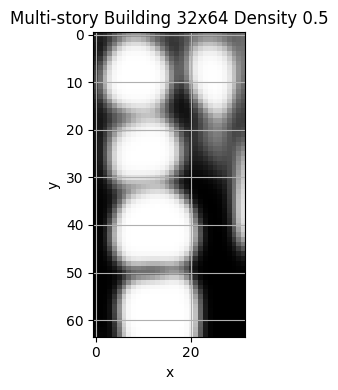

In [16]:
from scipy.ndimage import gaussian_filter

pygranso_structure = gaussian_filter(best_trial[1], sigma=1.2)
# pygranso_structure = best_trial[1]

# Plot the two structures together
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

# pygranso
ax1.imshow(pygranso_structure, cmap='Greys')
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Multi-story Building 32x64 Density 0.5')
fig.tight_layout()